In [24]:
from IPython.core.interactiveshell import InteractiveShell #Allow more than one output
InteractiveShell.ast_node_interactivity = "all"
!conda info


     active environment : impurityproject
    active env location : /home/aa2133/miniconda3/envs/impurityproject
            shell level : 2
       user config file : /home/aa2133/.condarc
 populated config files : 
          conda version : 4.11.0
    conda-build version : not installed
         python version : 3.8.3.final.0
       virtual packages : __linux=4.4.0=0
                          __glibc=2.23=0
                          __unix=0=0
                          __archspec=1=x86_64
       base environment : /home/aa2133/miniconda3  (writable)
      conda av data dir : /home/aa2133/miniconda3/etc/conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/linux-64
                          https://repo.anaconda.com/pkgs/r/noarch
          package cache : /home/aa2133/miniconda3/pkgs
                      

# Basic Functions

Basic functions needed for the balancing workflow

In [2]:
# %%writefile MainFunctions.py
# %load ./MainFunctions.py
from rdkit import Chem #Importing RDKit
from rdkit.Chem import Draw #For drawing molecules/reactions
from rdkit.Chem import rdChemReactions #Reaction processing
from rdkit.Chem.Draw import rdMolDraw2D #Drawing 2D molecules/reactions
from IPython.display import SVG  #For SVG support
from PIL import Image #Working with images
import io
import os #Working with the OS
try:
    import pickle5 as pickle #Only if pickle doesn't work
except Exception:
    import pickle
import cairosvg
import shutil
from rdkit.Chem import PeriodicTable, GetPeriodicTable
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
import ray
import modin.pandas as mpd

def initray(restart=True,num_cpus=16,log_to_driver=False):
    '''
    Initiates cluster of CPUs
    
    '''
    if restart:
        ray.shutdown()
    ray.init(num_cpus=num_cpus,log_to_driver=log_to_driver)

#%% Generating mol files

def molfromsmiles(SMILES):
    '''
    Converts a smiles string into a mol object for RDKit use. Also graphically
    represents molecule using matplotlib.

    Parameters
    ----------
    SMILES : String
        Smiles string of molecule

    Returns
    -------
    mol: RDKit mol object

    '''

    mol=Chem.MolFromSmiles(SMILES)
    Chem.SanitizeMol(mol)
    mol.UpdatePropertyCache(strict=False)
    return mol

def checksmiles(SMILES):
    '''
    Checks SMILES representation using RDkit for consistency
    
    '''
    mol=molfromsmiles(SMILES)
    SMILES2=Chem.MolToSmiles(mol)
    if SMILES2!=SMILES:
        msg='SMILES changed'
    else:
        msg='Valid'
    return SMILES2,msg

#%% Drawing reactions/mols


def mol_with_atom_index(mol):
    '''
    Draw a molecule with atom index numbers (set by RDKit)

    Parameters
    ----------
    mol : RDKit mol
        RDKit mol plain

    Returns
    -------
    mol : RDkit mol
        RDKit mol with atom indices

    '''
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol


def moveAtomMapsToNotes(m):
    '''
    Make note of the atom mapping

    Parameters
    ----------
    m : RDKit mol
      Mapped RDKit mol

    Returns
    -------
    RDKit mol with map numbers set as notes

    '''
    for at in m.GetAtoms():
        if at.GetAtomMapNum():
            at.SetProp("atomNote",str(at.GetAtomMapNum()))
            #at.SetAtomMapNum(0)

def drawReaction(rxn):
    '''
    Produces an SVG of a mapped reaction

    Parameters
    ----------
    rxn : String
        Reaction SMARTS string

    Returns
    -------
    SVG image

    '''
    trxn = rdChemReactions.ChemicalReaction(rxn)
    for m in trxn.GetReactants():
        moveAtomMapsToNotes(m)
    for m in trxn.GetProducts():
        moveAtomMapsToNotes(m)
    # if filetype=='svg':
#     d2d = rdMolDraw2D.MolDraw2DSVG(4000,500)
    d2d=rdMolDraw2D.MolDraw2DSVG(1000,300)
#     d2d.drawOptions().minFontSize = 20
    # else:
    #     d2d=rdMolDraw2D.MolDraw2DCairo(4000,500)

    d2d.DrawReaction(trxn,highlightByReactant=True)
    d2d.FinishDrawing()
    img=d2d.GetDrawingText()

    # if filetype=='svg':

    return SVG(img)
    # else:
    #     im=Image.open(io.BytesIO(img))
    #     return im
        # d2d.WriteDrawingText('text.png') #Only works with cairo, plus atom notes not included

def drawMol(m,filetype):
    '''
    Produces an SVG of RDKit mol
    
    Parameters
    ----------
    m : RDKit mol

    Returns
    -------
    SVG image

    '''
    if filetype=='svg':
        d=rdMolDraw2D.MolDraw2DSVG(400,300)
    else:
        d=rdMolDraw2D.MolDraw2DCairo(400,300)

    Draw.PrepareAndDrawMolecule(d,m)
    d.FinishDrawing()
    img=d.GetDrawingText()

    if filetype=='svg':
        return SVG(img)
    else:
        im=Image.open(io.BytesIO(img))
        return im
def highlightsubstruct(smi,pattlist=[]):
    m=molfromsmiles(smi)
    m=Chem.AddHs(m)
    hits_atsfin=[]
    hits_bondfin=[]
    for patt in pattlist:
        patt=Chem.MolFromSmarts(patt)
        hit_ats=[list(match) for match in m.GetSubstructMatches(patt)]
#                 hit_ats=[at for match in m.GetSubstructMatches(patt) for at in match]
        if not hit_ats:
            continue
        hit_bonds = []
        for bond in patt.GetBonds():
            for match in hit_ats:
                aid1 = match[bond.GetBeginAtomIdx()]
                aid2 = match[bond.GetEndAtomIdx()]
                hit_bonds.append(m.GetBondBetweenAtoms(aid1,aid2).GetIdx())
        hits_atsfin+=list(set([at for match in hit_ats for at in match]))
        hits_bondfin+=list(set(hit_bonds))
    colors=[(0.7,1,0.7)]
    atom_cols={}
    for i, at in enumerate(hits_atsfin):
        atom_cols[at] = colors[0]
    bond_cols = {}
    for i, bd in enumerate(hits_bondfin):
        bond_cols[bd] = colors[0]
    d = rdMolDraw2D.MolDraw2DSVG(500, 500) # or MolDraw2DCairo to get PNGs
    rdMolDraw2D.PrepareAndDrawMolecule(d, m, highlightAtoms=hits_atsfin,
                                        highlightBonds=hits_bondfin,highlightAtomColors=atom_cols,highlightBondColors=bond_cols)
    d.FinishDrawing()
    return SVG(d.GetDrawingText())

#%% Utility Functions
        
class CustomError(Exception):
    '''
    For error handling
    '''
    pass

def openpickle(filename):
    '''
    Takes a pickled file and loads it

    Parameters
    ----------
    filename : str
        File path of .pickle file

    Returns
    -------
    loadfile : Python object
        

    '''
    infile=open(filename,'rb')
    infile.seek(0)
    loadfile=pickle.load(infile)
    infile.close()
    return loadfile
    # with open('filename', 'rb') as handle: #Faster way
    # return pickle.load(handle)

def writepickle(pkl,directory,filename):
    '''
    Parameters
    ----------
    pkl : Python object
    
    filename : String
        Directory to save in (exclude extension)

    Returns
    -------
    None.

    '''
    if not os.path.exists(directory):
        os.makedirs(directory)
    with open(directory+filename+'.pickle', 'wb') as handle:
        pickle.dump(pkl, handle, protocol=pickle.HIGHEST_PROTOCOL)


def getlist(refdict,key):
    '''
    Gets list from a reference dictionary, given a key.
    Assumes refdict is a dictionary within a dictionary.
    
    Parameters
    ----------
    refdict : Dictionary
        Reference dictionary with keys as Reaxys ID
    key : String
        The reaction property that need to be retrieved

    Returns
    -------
    list: List of elements

    '''
    return [rxn[key] for rxn in refdict.values() if key in rxn.keys()]


def writetofile(rxnimg,directory):
    '''
    Takes a reaction image and saves it to a specified directory (usually after calling drawReaction)

    Parameters
    ----------
    rxnimg : Reaction sketch
    
    directory : String
        File path to write the image to

    Returns
    -------
    None.

    '''
    open(directory,'w').write(rxnimg.data)

def delcontents(directory):
    '''
    Deletes contents of a directory
    
    Parameters
    ----------
    directory : String
        Directory to delete

    Returns
    -------
    None.
    
    '''
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))



def convSVGtoPNG(filename, filenameout):
    '''
    Converts SVG images to PNG images for easier copy pasting (eg./ to Word)

    Parameters
    ----------
    filename : String
        File name of SVG image 
        
    filenameout : String
        File name of PNG image

    Returns
    -------
    None.

    '''
    cairosvg.svg2png(url=filename+".svg", write_to=filenameout+".png")

#%% Analyzing mol files

def atomtypes(mol):
    """
    Generates an atom type dictionary with counts for a given mol file. Also
    returns overall change of mol

    Parameters
    ----------
    mol : RDKit mol

    Returns
    -------
    typedict : dict
        Dictionary with keys as atom element and value as count
    charge : int
        Overall charge of supplied molecule

    """

    typedict={}
    mol2=Chem.AddHs(mol) #Assumes hydrogens are added
    charge=0
    for atom in mol2.GetAtoms():
        elem=PeriodicTable.GetElementSymbol(GetPeriodicTable(),atom.GetAtomicNum())
        charge+=atom.GetFormalCharge()
        if elem not in typedict.keys():
            typedict[elem]=1
        else:
            typedict[elem]+=1
    return typedict, charge

def getcompdict(ID=1,mol=None,smiles=None,formula=None,FragDB=None):
    '''
    Wrapper for atomtypes. ID must be input whether Reaxys ID or random number. Default is 1. 
    Smiles and mol can also be specified. Can be converted to an object instance if intended.

    Parameters
    ----------
    ID : int, optional
        ID of compound/mol. The default is 1.
    mol : RDKit mol, optional
        RDKit mol. The default is None.
    smiles : str, optional
        mol smiles. The default is None.
    formula : str, optional
        mol formula. The default is None.
    FragDB : Pandas dataframe, optional
        Pandas dataframe to find smiles of ID. The default is None.

    Raises
    ------
    CustomError
        Raises error if smiles/mol not specified, only ID specified
        without reference fragment dataframe. Also if anything specified
        is not valid/cannot be processed.

    Returns
    -------
    compddict : dict
        Compound dictionary with ID as key and another dictionary with the
        following keys: 'atomdict' (Output of atomtypes, dictionary with atom
        elements and count), 'charge' (Overall charge of mol),'smiles'
        (smiles of mol),'formula' (chemical formula),'count' (instance number, always 1)

    '''

    if smiles is None and mol is None:
        if FragDB is None:
            raise CustomError("Please provide a reference fragment database")
        try:
            smiles=locrecord(ID,FragDB,smiles=True)
        except Exception as e:
            raise CustomError("Compound "+str(ID)+" isn't in dataframe")
        try:
            mol=molfromsmiles(smiles)
        except Exception as e:
            raise CustomError("Compound "+str(ID)+" smiles is invalid")
    elif smiles:
        try:
            mol=molfromsmiles(smiles)
        except Exception as e:
            raise CustomError("Compound "+str(ID)+" smiles is invalid")
    if formula is None:
        formula=CalcMolFormula(mol)
    atomdata=atomtypes(mol)
    compddict={ID:{'atomdict':atomdata[0],'charge':atomdata[1],'smiles':smiles,'formula':formula,'count':1}}
    return compddict

#%% Database functions

def locrecord(ID,DB,smiles=False,fragsmarts=False,fragsmiles=False,mixture=False):
    '''
    Returns desired information by searching fragment database by ID

    Parameters
    ----------
    ID : int
        Substance ID to search for
    DB : pandas dataframe
        Fragment database with primary index as fragment smiles and secondary index as substance ID
    smiles : bool, optional
        Specify True if only smiles needs to be returned. The default is False.
    fragsmarts : bool, optional
        Specify True if only fragment smarts need to be returned. The default is False.
    fragsmiles : bool, optional
        Specify True if only fragment smiles needs to be returned . The default is False.
    mixture : bool, optional
        Specify True if only mixture presence needs to be returned. The default is False.

    Returns
    -------
    Output : pandas row or str depending on input preference. If everything is False, row will be returned

    '''

    record=DB.xs(ID,level=1)
    if smiles:
        return record.Smiles.unique()[0]
    if fragsmarts:
        return record.FragmentSmarts.values
    if fragsmiles:
        return record.index.values
    if mixture:
        return record['>1 Compound'].unique()[0]
    return record

#%% Joining smiles

def getfragments(chemlist,smiles=False,ref=None):
    '''
    Concatenates smiles strings in a list separated by '.' If ID's are given instead,
    looks up IDs in reference dictionary or database.

    Parameters
    ----------
    chemlist : list
        List of smiles strings OR substance IDs
    ref : dict/database (Optional if list of smiles, mandatory if list of IDs)
        If database provided should be multiindexed with smiles string attached to the ID as key. 
        At the moment only fragment database allowed.
    smiles: bool
        Indicate if chemlist is smiles or not

    Returns
    -------
    frag : str
        String joining all smiles given in/calculated from chemlist with '.' operator

    '''
    if chemlist==[]:
        raise CustomError('ERROR: NO CHEMICALS IN LIST PROVIDED')
    if smiles: #List of smiles provided
        return '.'.join(chemlist)
    else: #List of IDs given
        if ref is None:
            raise CustomError("Please supply reference (fragment) database multiindexed with ID as second level and containing a Smiles column")
        try:
            frag='.'.join([locrecord(ID,ref,smiles=True) for ID in chemlist])
        except Exception:
            raise CustomError('One or more compounds missing from database')
        else:
            return frag

# Help Compounds

Help compound dictionaries...change accordingly

In [3]:
# %%writefile helpCompound.py
# %load ./helpCompound.py

from rdkit import Chem


# help compounds
# website to draw structure and compute SMILES:
# http://www.cheminfo.org/flavor/malaria/Utilities/SMILES_generator___checker/index.html
# or ChemDraw
hc_smilesDict = {
    'CH3COOH': 'CC(=O)O',
    'H2O': 'O',
    'H2': '[H][H]',
    'O2': 'O=O',
    'NH3': 'N',
    'N2': 'N#N',

    'Na+': '[Na+]',
    'K+': '[K+]',
    'NO2+': 'O=[N+]=O',
    'SO3-': 'O=S(O)[O-]',

    'CH4': 'C', #H2O was after this
    'HCl': 'Cl',
    'HBr': 'Br',
    'HI': 'I',
    'HF': 'F',
    'PH3': 'P', #NH3 was after this
#     'NH3': 'N',
    'H2S': 'S',

    'H3PO3': 'O=P(O)O',
    'H2SO4': 'O=S(=O)(O)O',
    'HNO3': 'O=N(=O)O',
    'HClO3': 'O=Cl(=O)O',

    'CH3OH': 'CO',
    'CH3CH2OH': 'CCO',  # ethanol
    'CH3CH2CH2OH': 'CCCO',
    'CH3CH2CH2CH2OH': 'CCCCO', #ethanoic acid was after this

#     'CH3COOH': 'CC(=O)O',
    'CH3CH2COOH': 'CCC(=O)O',
    'CH3CH2CH2COOH': 'CCCC(=O)O',

    'CH3OCH2COOH': 'COCC(=O)O',

    'C6H6': 'c1ccccc1',  # benzene
    'C6H5CH3': 'Cc1ccccc1',  # toluene
    'C6H5OH': 'Oc1ccccc1',  # phenol
    'C6H5Cl': 'Clc1ccccc1'
}

rxs_ids= {
    0: [506007],
    1: [16478368,
      18259376,
      16999929,
      17669282,
      16532872,
      28692842,
      15936966,
      3587155,
      16490171,
      16289331,
      16835842,
      16503633,
      17718728,
      6133474,
      16262803,
      16474573,
      3902901,
      16475737,
      28983178,
      15994867,
      17669283,
      15937459,
      16953050,
      15994744,
      15994743,
      14405424,
      16485385,
      16484106,
      16733579],
    2: [28182329, 16514685, 23163263, 27944166, 3587189, 16818691],
    3: [16770786,
      3587218,
      31585248,
      22989299,
      27987247,
      16504248,
      16514885,
      11335911,
      26591375,
      4950925,
      30719131,
      16855942,
      16868313],
    4: [14975703,
      3587154,
      16481245,
      14680594,
      16513264,
      16051411,
      16752555,
      16497709,
      17464070,
      9757005,
      16853108,
      16645898,
      16344183,
      16480090,
      16504355],
    5: [18239691, 23131181, 16825577, 3535119],
    6: [],
    7: [],
    8: [],
    9: [],
    10: [24624233,
      16418587,
      23479886,
      15997356,
      16819140,
      27580429,
      16707704,
      16707699,
      16504514,
      23044551,
      16733525,
      16609798,
      5489265,
      16305234,
      1718732,
      17199598,
      30914243,
      22919006,
      16290583,
      17121186,
      17606888,
      8253279,
      16512586,
      16210409,
      18183425,
      8137357,
      31767133,
      16488242,
      19714291,
      16708305,
      16021303,
      16515430,
      23009402,
      6378772,
      31939934,
      16030247,
      15900809,
      22939136,
      4360473,
      16014509,
      17182792,
      27904106,
      27027367,
      18162417,
      22923218,
      22966207,
      18162513,
      16704909,
      16504771,
      16770476,
      23124799,
      23669189],
    11: [24608586,
      16836402,
      14681183,
      3587171,
      15913435,
      16501060,
      7801727,
      16270663,
      19834398,
      1098214,
      16475562,
      16502419,
      3587163],
    12: [19231194,
      3587158,
      16767870,
      16953049,
      32435652,
      8137367,
      16350067,
      17252122,
      3587179,
      7801728,
      3587164],
    13: [19235722,
      4857092,
      3587159,
      7801729,
      13260132,
      3924806,
      15654752,
      13191432,
      3587184,
      14314981,
      7183122],
    14: [17804308,
      9189014,
      16845862,
      22706559,
      30535914,
      29920556,
      31535339,
      27914016,
      15346168,
      3535002,
      31364145,
      7631393,
      16484530,
      12273154,
      31497443,
      31990450,
      3587168],
    15: [3600171,
      16637179,
      16124019,
      28173516,
      11342918,
      16700864,
      16124280,
      17038085,
      16477580,
      23024892,
      16537462,
      16079940,
      16835703,
      16818083,
      16819540,
      16085506,
      22927825,
      16844873,
      16840622,
      16823091],
    16: [16502675,
      21096201,
      18146804,
      16882310,
      18081525,
      16756646,
      16756647,
      16482190,
      15993707,
      16812026,
      16744421,
      16506507,
      16860251,
      16866405,
      18088677,
      16023721,
      16479810,
      29006369,
      16856368,
      16708589,
      16733544,
      16833861,
      16742934,
      16771669,
      4921294,
      16815166,
      16505834,
      16866223,
      3902903,
      16514169,
      16861985,
      16510798,
      16862395,
      15917942,
      16509361,
      3535004,
      16863400],
    17: [1209272],
    18: [18778845, 27746102, 19242250, 2037554],
    19: [3587310],
    20: [3903350],
    21: [5725793, 1098229, 6378986],
    22: [1718733, 7125196, 6379086],
    23: [1098242],
    24: [6184745, 969148, 5725719],
#     24: [506007],
    25: [30634768, 506071],
    26: [906770],
    27: [635800],
    28: [4921477, 969212, 4124568, 3648202],
    29: [3928623, 28376744, 5242344, 635760, 4952623],
    30: [5805786, 969616, 4244235],
    31: [3603072, 605632, 6190543]}

hc_smilesDict={hcid:Chem.MolToSmiles(Chem.MolFromSmiles(hcsmiles)) for hcid,hcsmiles in hc_smilesDict.items()}
# rxs_ids={i:list(pd.read_sql_query('''SELECT SubstanceID from SubstanceDB Where Smiles= "'''+hcsmiles+ '''"'''+'''AND ">1 Compound"=0''',db).SubstanceID) for i,hcsmiles in enumerate(hc_smilesDict.values())}

hc_molDict = {hc: Chem.AddHs(Chem.MolFromSmiles(
    hc_smilesDict[hc])) for hc in hc_smilesDict}
hc_Dict={i:getcompdict(ID=i,smiles=hcsmiles)[i] for i,hcsmiles in enumerate(hc_smilesDict.values())}
for i in hc_Dict.keys():
    hc_Dict[i].update({'rxs_ids':rxs_ids[i]})
hc_rct={hcid:hc_Dict[hcid] for hcid in [1,2,3,10,11,12,13,14]} #Small compounds to add to LHS 

# Balancing

Main balancing algorithms

In [4]:
# %%writefile BalanceRxns.py
# %load ./BalanceRxns.py
import rdkit
import multiprocessing
import time
from chempy import balance_stoichiometry
import copy
from collections import Counter
from decimal import Decimal, ROUND_HALF_UP
from rdkit import Chem #Importing RDKit
from rdkit.Chem import rdChemReactions #Reaction processing
from math import ceil


def balance_analogue_(analoguerxns,refbalrxns=None,coefflim=6,reaxys_update=True,includesolv=True,
                     usemapper=True,helpprod=True,helpreact=False,addrctonly=False,ignoreH=False,ncpus=16,restart=True):
    '''
    Applies balance_analogue across each row of a given dataframe
    
    '''
#     breakpoint()
    if not analoguerxns.index.name and (not analoguerxns.index.names or None in analoguerxns.index.names):
        idxreset=True
    else:
        idxreset=False
    idxcol=[]
    if reaxys_update:
        idxcol=['ReactionID','Instance']
    else:
        idxcol=['ReactionID']
    if refbalrxns is not None:
        analoguerxns,commondf=userefrxns(analoguerxns,idxcol=idxcol,refanaloguerxns=refbalrxns)
        idxreset=False
    if not analoguerxns.empty:
        if ncpus>1:
            if restart:
                initray(num_cpus=ncpus)
            if not idxreset:
                analoguerxns.reset_index(inplace=True)
                idxreset=True
            analoguerxnsdis=mpd.DataFrame(analoguerxns)
        else:
            analoguerxnsdis=analoguerxns
        balrxns=analoguerxnsdis.apply(balance_analogue,coefflim=6,includesolv=includesolv,usemapper=usemapper,
                                   helpprod=helpprod,helpreact=helpreact,addrctonly=addrctonly,ignoreH=ignoreH,axis=1,result_type='reduce')
        balrxns=pd.Series(data=balrxns.values,index=balrxns.index) #Optional convert modin back to pandas
        analoguerxnsbal=pd.DataFrame(balrxns,columns=['rxnsmiles'])
        analoguerxnsbal[['rxnsmiles0', 'balrxnsmiles','msg','LHS','RHS','hcrct','hcprod','LHSdata','RHSdata']] = pd.DataFrame(analoguerxnsbal['rxnsmiles'].tolist(), index=analoguerxnsbal.index)
        analoguerxnsbal[['NumRefs','NumSteps','NumStages']]=analoguerxns[['NumRefs','NumSteps','NumStages']]
        cols=['NumRefs','NumSteps','NumStages','rxnsmiles0','balrxnsmiles','msg','LHS','RHS','hcrct','hcprod','LHSdata','RHSdata']
#         breakpoint()
        if idxreset:
            analoguerxnsbal[idxcol]=analoguerxns[idxcol]
            cols=idxcol+cols
        analoguerxnsbal=analoguerxnsbal[cols]
        if idxreset:
            analoguerxnsbal.set_index(idxcol,inplace=True)
        if refbalrxns and not commondf.empty: #Indices need to match!
            analoguerxnsbal=pd.concat([analoguerxnsbal,commondf])
    else:
        analoguerxnsbal=commondf
        balrxns=[]
    return balrxns,analoguerxnsbal

def balance_analogue(row,basic=True,balance=True,coefflim=6,includesolv=True,
                     usemapper=True,helpprod=True,helpreact=False,addrctonly=False,ignoreH=False): #More reliable
    '''
    Applies balancerxn function across a given dataframe row
    
    
    '''
    Rdata={}
    Pdata={}
    Rgtdata={}
    Solvdata={}
    Rgtid=[]
    hc_prod={}
    hc_react={}
    Rdata=copy.deepcopy(row['Rdata'])
    Pdata=copy.deepcopy(row['Pdata'])
    Rgtdata=copy.deepcopy(row['Rgtdata'])
    if 'reagentID' in row and row['ReagentID']!='NaN':
        Rgtid=copy.deepcopy(row['ReagentID'])
    if helpprod:
        hc_prod=copy.deepcopy(row['hc_prod'])
    if helpreact:
        hc_react=copy.deepcopy(row['hc_react'])
    if includesolv:
        Solvdata=copy.deepcopy(row['Solvdata'])
    if type(Rdata)!=dict: #Error or compound invalid
        if basic and balance:
            return 'Error','Error',Rdata,'NaN','NaN',[],[],'NaN','NaN'
        else:
            return 'Error',Rdata,'NaN','NaN',[],[],'NaN','NaN' 
    elif type(Pdata)!=dict: #Error or compound invalid
        if basic and balance:
            return 'Error','Error',Pdata,'NaN','NaN',[],[],'NaN','NaN'
        else:
            return 'Error',Pdata,'NaN','NaN',[],[],'NaN','NaN' 
    rxnsmiles0='>>'.join([getfragments([Rdata[r]['smiles'] for r in Rdata],smiles=True),
                          getfragments([Pdata[p]['smiles'] for p in Pdata],smiles=True)])
    if basic and not balance:
        return rxnsmiles0,list(Rdata.keys()),list(Pdata.keys())
    else:
#         return False
#         breakpoint()
        return balancerxn(Rdata,Pdata,Rgtdata=Rgtdata,Solvdata=Solvdata,rxnsmiles0=rxnsmiles0,usemapper=usemapper,
                          coefflim=coefflim,hc_prod=hc_prod,hc_react=hc_react,addrctonly=addrctonly,ignoreH=ignoreH)

def balancerxn(Rdata,Pdata,Rgtdata={},Solvdata={},rxnsmiles0=None,first=True,usemapper=True,
               addedspecies=[],addedhc=[],hc_prod={},hc_react={},coefflim=6,msg='',mandrcts={},addrctonly=False,
               ignoreH=False):
    '''
    Balances reactions given reactant species information (Rdata) and product species information (Pdata)
    
    Rgtdata is optional and refers to reagent species information
    Solvdata is optional and refers to solvent species information
    rxnsmiles0 refers to the reaction SMILES string as represented in Reaxys
    first is True/False depending on whether it is the first time running through the code
    usemapper is True if IBM RXN mapper is used to decide between possible reactants on LHS
    addedspecies refers to new species added to the LHS
    addedhc refers to small species (help reactants) added to the LHS
    hc_prod is optional and is a dictionary of small species (help compounds) to use for balancing the RHS
    hc_react is optional and is a dictionary of small species (help reactants) to use for balancing the LHS
    coefflim refers to the maximum allowed stoichiometric coefficient after balancing
    msg involves any warning messages or updates from the code
    mandrcts is a list of mandatory reactants (To avoid balancer from removing them)
    ignoreH refers to a boolean switch (True if all hydrogen species except H2 are ignored/not added)
    
    '''
    
    if Solvdata: #Add sovents
        Rgtdata={**Rgtdata,**Solvdata} #Newly added
        
    #%% Initialize added species/addedhc (help compound) and add small species
    if first:
        addedspecies=[]
        addedhc=[]
        if not mandrcts:
            mandrcts=copy.deepcopy(Rdata)
        if Rgtdata:
#             smallspecies=[spec for spec in Rgtdata if Rgtdata[spec]['formula'] in ['H2','O2','H2O','OH2','HOH'] if spec not in Solvdata]
#             smallspecies=[spec for spec in Rgtdata if Rgtdata[spec]['formula'] in ['H2','O2','H2O','OH2','HOH']]
            smallspecies=[spec for spec in Rgtdata if Rgtdata[spec]['formula'] in ['H2','O2']]
            if smallspecies:
                Rdata.update({spec:Rgtdata[spec] for spec in smallspecies})
                addedspecies+=smallspecies


    #%% String output handling
    addedstr=''
    if addedspecies:
        addedstr=','.join([str(species) for species in set(addedspecies) if species not in mandrcts])
        if addedstr:
            addedstr=' with species: '+addedstr
    if addedhc:
        addedstr2=','.join([hc_react[species]['formula'] for species in set(addedhc) if species not in mandrcts])
        if addedstr2:
            addedstr2=' with help reactant(s): '+addedstr2
        if addedstr:
            addedstr=addedstr+', '+addedstr2
        else:
            addedstr=addedstr2
#     if 'Mandatory' in msg or 'Smiles discrepancy' in msg:
    if 'Smiles discrepancy' in msg:
        msg=msg+addedstr
        return update_rxn(mandrcts,Pdata,hc_prod=hc_prod,hcrct=addedhc,rxnsmiles0=rxnsmiles0,msg=msg)
    if 'Hydrogen carriers' in msg:
        msg=msg+addedstr
        return update_rxn(Rdata,Pdata,hc_prod=hc_prod,hcrct=addedhc,rxnsmiles0=rxnsmiles0,msg=msg)            

    Rcount=sum([Counter(Rdata[ID]['atomdict']) for ID in Rdata for _ in range(Rdata[ID]['count'])],start=Counter()) #Sum of atom counts/types on LHS
    Rcharge=sum([Rdata[ID]['charge'] for ID in Rdata for _ in range(Rdata[ID]['count'])])
    Pcount=sum([Counter(Pdata[ID]['atomdict']) for ID in Pdata for _ in range(Pdata[ID]['count'])],start=Counter()) #Sum of atom counts/types on RHS
    Pcharge=sum([Pdata[ID]['charge'] for ID in Pdata for _ in range(Pdata[ID]['count'])])
            
    #%% If reaction is balanced already
    if Rcount==Pcount and Rcharge==Pcharge:
        print('Reaction is fully balanced')
        if first:
            msg='Already balanced'
        elif msg:
            msg=msg+', '+'Balanced'
        else:
            msg='Balanced'
        if addedstr:
            msg+=addedstr
        return update_rxn(Rdata,Pdata,hcrct=addedhc,rxnsmiles0=rxnsmiles0,msg=msg)

        
#%% Otherwise take difference between atom type/count RHS and LHS

    rem=Counter() # Rem contains difference between product and reactant counters
    rem.update(Pcount)  #If atoms not balanced and same charge, attempt to balance. Can try if different charge but more tricky
    rem.subtract(Rcount) #Subtracting reactant atom type index from product atom type index
    postype={key:rem[key] for key in rem.keys() if rem[key]>0} #Finding only positive keys. Note that if counter is positive this means extra molecules need to be added on LHS (eg. reagent).
    negtype={key:abs(rem[key]) for key in rem.keys() if rem[key]<0} #Finding only negative keys. If counter is negative this means extra molecules need to be added on RHS (eg. help compounds)

#     breakpoint()        

    if postype: #Reactants, Reagents may be needed 
        status=[mandrcts[ID0]['count']>Rdata[ID0]['count'] for ID0 in mandrcts if ID0 in Rdata] #if ID0 in Rdata
        if any(status):
            if msg:
                msg=msg+', '+'Mapping error'+addedstr
            else:
                msg='Mapping error'+addedstr
            return update_rxn(Rdata,Pdata,hc_prod=hc_prod,hcrct=addedhc,rxnsmiles0=rxnsmiles0,msg=msg)
        #%% Initializing variables
        candirxt=[]
        candirgt=[]
        candihc=[]
        matches=[]
        addedspecies_=[]
        addedhc_=[]
        #%% Get reactant match first
        candirxt=[rctid for rctid in Rdata if set(postype.keys()).issubset(set(Rdata[rctid]['atomdict'].keys()))]
        #%% Get reagent match
        candirgt=[rgtid for rgtid in Rgtdata if set(postype.keys()).issubset(set(Rgtdata[rgtid]['atomdict'].keys())) and rgtid not in candirxt]                        
        #%% Get help compound match
        if hc_react:
            candihc=[hcid for hcid in hc_react if set(postype.keys()).issubset(set(hc_react[hcid]['atomdict'].keys()))]
#         breakpoint() 
        if candirxt and not candirgt: #Only reactant matches
            Rdata,addedspecies_,msg_=resolvecandidates(postype,Rdata,Rdata,candirxt,Pdata,validate=False,rctonly=addrctonly,ignoreH=ignoreH)
        elif candirgt and not candirxt:
            Rdata,addedspecies_,msg_=resolvecandidates(postype,Rdata,Rgtdata,candirgt,Pdata,validate=False,rctonly=False,ignoreH=ignoreH)
        elif candirxt and candirgt:
            Rdata,addedspecies_,msg_=resolvecandidates(postype,Rdata,{**Rdata,**Rgtdata},candirxt+candirgt,Pdata,validate=False,rctonly=addrctonly,ignoreH=ignoreH)
        elif not candirxt and not candirgt:
            combineddict={**Rdata,**Rgtdata}
            candispec=[specid for specid in combineddict if set(combineddict[specid]['atomdict'].keys()).intersection(set(postype.keys()))]
            if not candispec:
                msg_='LHS species insufficient'
            else:
                Rdata,addedspecies_,msg_=resolvecandidates(postype,Rdata,combineddict,candispec,Pdata,rctonly=addrctonly,ignoreH=ignoreH)
        elif candihc and not candirxt and not candirgt:
            Rdata,addedhc_,msg_=resolvecandidates(postype,Rdata,hc_react,candihc,Pdata,validate=False,rctonly=addrctonly,ignoreH=ignoreH)
        if 'Hydrogen carriers' in msg_: #Multiple candidates for hydrogen carriers (mapper won't help)
            if msg:
                msg=msg+', '+msg_
            else:
                msg=msg_
            
        elif msg_!='Valid': #Atom surplus on RHS cannot be met by any LHS species
            if msg:
                msg=msg+', '+msg_+addedstr
            else:
                msg=msg_+addedstr
            return update_rxn(Rdata,Pdata,hc_prod=hc_prod,hcrct=addedhc,rxnsmiles0=rxnsmiles0,msg=msg)

        else:
            addedspecies+=addedspecies_
            if addedhc_:
                adddedhc+=addedhc_
            #New#
            if len(postype)==1 and 'H' in postype and 'With hydrogen carriers' not in msg:
                if msg:
                    msg=msg+', '+'With hydrogen carriers: '+','.join([str(addedspec) for addedspec in addedspecies_])
                else:
                    msg='With hydrogen carriers: '+','.join([str(addedspec) for addedspec in addedspecies_])
            #New#
#         breakpoint()
        return balancerxn(Rdata,Pdata,Rgtdata=Rgtdata,rxnsmiles0=rxnsmiles0,first=False,usemapper=usemapper,
                         addedspecies=addedspecies,addedhc=addedhc,hc_prod=hc_prod,
                         hc_react=hc_react,coefflim=coefflim,msg=msg,mandrcts=mandrcts,addrctonly=addrctonly,ignoreH=ignoreH) 
    
    elif negtype:
#         breakpoint()
        if usemapper and len(set(addedspecies))>1: #More than one choice or added small species, let the mapper decide
            rxnsmiles=buildrxn(Rdata,Pdata)
            mapped_rxn=maprxn([rxnsmiles])[0]
            if mapped_rxn=='Error':
                if not addrctonly:
                    addrctonly=True
                    candidates2=[candi for candi in Rdata if candi in mandrcts]
                    if candidates2 and candidates2!=list(Rdata.keys()):
                        Rdata={ID0:Rdata[ID0] for ID0 in candidates2}
                        addedspecies=[addedspec for addedspec in addedspecies if addedspec in Rdata]
                        if addedhc:
                            addedhc=[addedh for addedh in addedhc if addedh in Rdata]
                        return balancerxn(Rdata,Pdata,rxnsmiles0=rxnsmiles0,first=False,usemapper=usemapper,
                                         addedspecies=addedspecies,addedhc=addedhc,hc_prod=hc_prod,hc_react=hc_react,
                                         coefflim=coefflim,msg=msg,mandrcts=mandrcts,addrctonly=addrctonly,ignoreH=ignoreH)
                
                if all([Rdata[ID0]['count']==1 for ID0 in Rdata]) or any([Rdata[ID0]['count']>=10 for ID0 in Rdata]):
                    if msg:
                        msg=msg+', '+'Mapping error'+addedstr
                    else:
                        msg='Mapping error'+addedstr
                    return update_rxn(Rdata,Pdata,hc_prod=hc_prod,hcrct=addedhc,rxnsmiles0=rxnsmiles0,msg=msg)
                else:  
                    status=[mandrcts[ID0]['count']>=Rdata[ID0]['count'] for ID0 in mandrcts if ID0 in Rdata] #if ID0 in Rdata
                    if any(status):
                        for ID0 in Rdata:
                            Rdata[ID0]['count']=Rdata[ID0]['count']-1
                    else:
                        mandrcts=copy.deepcopy(Rdata)
                        mincount=min([Rdata[ID0]['count'] for ID0 in Rdata])
                        for ID0 in Rdata:
                            Rdata[ID0]['count']=mincount
                    return balancerxn(Rdata,Pdata,rxnsmiles0=rxnsmiles0,first=False,usemapper=usemapper,
                                    addedspecies=addedspecies,addedhc=addedhc,hc_prod=hc_prod,hc_react=hc_react,
                                    coefflim=coefflim,msg=msg,mandrcts=mandrcts,addrctonly=addrctonly,ignoreH=ignoreH)
            else:
                mappedrxn=mapped_rxn.get('mapped_rxn')
                if 'With hydrogen carriers' in msg:
                    hcarriers=[int(hcarrier) for hcarrier in msg.split('With hydrogen carriers: ')[1].split(', ')[0].split(',')]
                else:
                    hcarriers=[]
#                 breakpoint()
                LHSdata,_,msg_=checkrxn(mappedrxn,Rdata=Rdata,updateall=False,mandrcts=list(mandrcts.keys()),hcarriers=hcarriers)
                if 'Mandatory' in msg_ and not addrctonly:#Reactants are unmapped (Try again with a smaller candidate selection)
                    return balancerxn(mandrcts,Pdata,Rgtdata=Rgtdata,rxnsmiles0=rxnsmiles0,first=True,usemapper=usemapper,
                             addedspecies=addedspecies,addedhc=addedhc,hc_prod=hc_prod,
                             hc_react=hc_react,coefflim=coefflim,msg=msg,addrctonly=True,ignoreH=ignoreH)
                if msg:
                    if msg_!='Valid':
                        msg=msg_+', '+msg
                    msg='Mapper used'+', '+msg
                else:
                    if msg_!='Valid':
                        msg='Mapper used'+', '+msg_
                    else:
                        msg='Mapper used'
            if addedhc:
                addedhc=[addedh for addedh in addedhc if addedh in LHSdata]  
#             breakpoint()
            addedspecies=[addedspec for addedspec in addedspecies if addedspec in LHSdata]
            return balancerxn(LHSdata,Pdata,Rgtdata=Rgtdata,rxnsmiles0=rxnsmiles0,first=False,usemapper=False,
                             addedspecies=addedspecies,addedhc=addedhc,hc_prod=hc_prod,hc_react=hc_react,coefflim=coefflim,
                             msg=msg,mandrcts=mandrcts,addrctonly=addrctonly,ignoreH=ignoreH)
        else:
#             breakpoint()
            # Find match with Rdata first
            candidates=[spec for spec in Rdata if Rdata[spec]['atomdict']==negtype if spec in addedspecies]
            if not candidates:
                candidates=[spec for spec in Rdata if set(Rdata[spec]['atomdict'].keys())==set(negtype.keys()) if spec in addedspecies]
            if candidates:
                specremoved=False
                for candi in candidates:
                    matcharray=list(set(Counter({k:negtype[k]/Rdata[candi]['atomdict'][k] for k in negtype}).values()))
                    if all([mult.is_integer() for mult in matcharray]):
                        mult=min(matcharray)
                        newcount=int(Rdata[candi]['count']-mult)
                        if newcount<0:
                            newcount=0
                        if newcount==0:
                            del Rdata[candi]
                        else:
                            Rdata[candi]['count']=newcount
                        specremoved=True
                        break
                if specremoved:
                    if addedhc:
                        addedhc=[addedh for addedh in addedhc if addedh in Rdata]
#                         refhc=Counter(addedhc)
#                         addedhc=[addedspec for addedspec in Rdata for _ in range(min([Rdata[addedspec]['count'],refhc[addedspec]])) if addedspec in addedhc]
                    addedspecies=[addedspec for addedspec in addedspecies if addedspec in Rdata]
#                     refspec=Counter(addedspecies)
#                     addedspecies=[addedspec for addedspec in Rdata for _ in range(min([Rdata[addedspec]['count'],refspec[addedspec]])) if addedspec in addedspecies if addedspec not in addedhc] 
                    if 'Mixture' in msg:
                        msglist=msg.split(',')
                        msglist2=copy.copy(msglist)
                        for i,msg_ in enumerate(msglist):
                            if 'Mixture' in msg_:
                                mixmsg=msg_.split(':')
                                refmixtures=mixmsg[1].split(',')
                                rmixtures={rmixture for rmixture in refmixtures if rmixture in Rdata}
                                if rmixtures:
                                    msglist2[i]=mixmsg[0]+','.join(rmixtures)
                                else:
                                    msglist2.remove(msglist2[i])
                                msg=', '.join(msglist2)
                    return balancerxn(Rdata,Pdata,Rgtdata=Rgtdata,rxnsmiles0=rxnsmiles0,first=False,usemapper=False,
                                  addedspecies=addedspecies,addedhc=addedhc,hc_prod=hc_prod,hc_react=hc_react,
                                  coefflim=coefflim,msg=msg,addrctonly=addrctonly,ignoreH=ignoreH)
                        
            # Then try help compounds
            if Rcharge==Pcharge:
                hc_prod={hcid:hc_prod[hcid] for hcid in hc_prod if hc_prod[hcid]['charge']==0} #Atom type for help compounds

            hc_prod2={hcid:hc_prod[hcid] for hcid in hc_prod if hc_prod[hcid]['atomdict']==negtype} #Exact match for 1 compound
            if not hc_prod2:
                hc_prod2={hcid:hc_prod[hcid] for hcid in hc_prod if hc_prod[hcid]['atomdict'].keys()==negtype.keys()} #Key match for 1 compound
            if hc_prod2:
                balbefore=False
            else:
                balbefore=True
            reac={}
            prod={}
            hcid=[]
            try:
                reac,prod,hcid,msg0=balance(Rdata,Pdata,hc_prod=hc_prod2,balbefore=balbefore,coefflim=coefflim,
                                            addedspecies=[addedspec for addedspec in addedspecies if addedspec not in mandrcts],
                                            addedhc=[addedh for addedh in addedhc if addedh not in mandrcts],hc_react=hc_react)
                if msg:
                    msg=msg+', '+msg0
                else:
                    msg=msg0
            except Exception:
                if not balbefore:
                    return balancerxn(Rdata,Pdata,Rgtdata=Rgtdata,rxnsmiles0=rxnsmiles0,first=False,usemapper=False,
                                  addedspecies=addedspecies,addedhc=addedhc,hc_prod={},hc_react=hc_react,
                                  coefflim=coefflim,msg=msg,addrctonly=addrctonly,ignoreH=ignoreH)
                if Rcharge!=Pcharge:
                    if msg:
                        msg=msg+', '+'Charge imbalance'
                    else:
                        msg='Charge imbalance'
                if msg: 
                    msg=msg+', '+'RHS species insufficient'+addedstr
                else:
                    msg='RHS species insufficient'+addedstr
                
                return update_rxn(Rdata,Pdata,hcrct=addedhc,rxnsmiles0=rxnsmiles0,msg=msg)
            else:
                if Rcharge!=Pcharge:
                    if msg:
                        msg=msg+', '+'Charge imbalance'+addedstr
                    else:
                        msg='Charge imbalance'+addedstr
                return update_rxn(Rdata,Pdata,reac=reac,prod=prod,hcprod=hcid,hc_prod=hc_prod2,hcrct=addedhc,
                                  rxnsmiles0=rxnsmiles0,msg=msg)
    else:
        if Rcharge!=Pcharge:
            if msg:
                msg=msg+', '+'Charge imbalance'+addedstr
            else:
                msg='Charge imbalance'+addedstr
        return update_rxn(Rdata,Pdata,hc_prod=hc_prod,hcrct=addedhc,
                        rxnsmiles0=rxnsmiles0,msg=msg)
        


def buildrxn(Rdata,Pdata):
    '''
    Takes reaction and product data, and concatenates smiles strings, forming
    reaction smiles/smarts

    '''
    LHS=[Rdata[ID]['smiles'] for ID in Rdata for _ in range(Rdata[ID]['count'])]
    RHS=[Pdata[ID]['smiles'] for ID in Pdata for _ in range(Pdata[ID]['count'])]
    return '>>'.join([getfragments(LHS,smiles=True), getfragments(RHS,smiles=True)])


def update_stoich(stoich,compdict,hcID=None,hc_Dict=None):
    '''
    Based on balanced stoichiometry output of balance_stoichiometry function from chempy, and given a 
    dictionary of help compounds and relevant help IDs, updates species dictionary
    '''
    usedid=[]
    formdict={}
    msg=''   
    for ID in compdict:
        form=compdict[ID]['formula']
        if form not in formdict:
            formdict.update({form:[ID]})
        else:
            formdict[form].extend([ID])
#     breakpoint()
    if hcID:
        if hc_Dict is None:
            raise CustomError("Please supply help compound reference dictionary/dataframe")
        for hcid in hcID:
            form=hc_Dict[hcid]['formula']
            if form not in formdict:
                formdict.update({form:[hcid]})
            else:
                formdict[form].extend([hcid])
    for formula,coeff in stoich.items():
        if formula in formdict:
            for ID in formdict[formula]:
                if ID not in compdict:
                    compdict.update({ID:hc_Dict[ID]})
                compdict[ID]['count']=coeff
                usedid+=[ID]
        else:
            msg='Invalid balancing. Formula indicated in stoich outside compound dictionary'
            break
    if msg:
        return 'Error',msg,formdict
    else:
        valid=True
        unusedid=set(compdict.keys())-set(usedid)
        if unusedid:
            for ID in unusedid:
                if 'rxs_ids' not in compdict[ID]: #Identifying help compounds
                    valid=False
                    break
            if valid:
                for ID in unusedid:
                    del compdict[ID] # 'Reactants' that aren't reactants..these are removed
        if valid and compdict:
            return compdict,msg,formdict
        else:
#             breakpoint()
            msg='Invalid balancing. Species missing: '+','.join([str(unused) for unused in unusedid])
            return compdict,msg,formdict
        

def update_rxn(Rdata,Pdata,reac=None,prod=None,hc_prod=None,hcprod=[],hcrct=[],rxnsmiles0=None,msg=None):
    '''
    Wrapper for calling update_stoich function 
    
    '''
    stoichupdated=False
    addmsgr=''
    addmsgp=''
    if reac is not None:#Switched order
        stoichupdated=True
        Rdata1,addmsgr,formdictr=update_stoich(reac,Rdata)
    if prod is not None:
        stoichupdated=True
        Pdata1,addmsgp,formdictp=update_stoich(prod,Pdata,hcID=hcprod,hc_Dict=hc_prod)     
    if addmsgr and addmsgr!='Valid':
        if msg is not None:
            msg=addmsgr+' from LHS'+', '+msg
        else:
            msg=addmsgr+' from LHS'
    if addmsgp and addmsgp!='Valid':
        if msg is not None:
            msg=addmsgp+' from RHS'+', '+msg
        else:
            msg=addmsgp+' from RHS'
    if stoichupdated:
        if Rdata1!='Error' and Pdata1!='Error':
            Rdata=Rdata1
            Pdata=Pdata1
            try:
                balrxnsmiles=buildrxn(Rdata,Pdata)
            except Exception:
                balrxnsmiles='Error'
                msg='Invalid balancing. Species missing in database'+', '+msg #Just to make sure, although this error should never happen
        else:
            balrxnsmiles='Error'
    else:
        if ('LHS species insufficient' in msg) | ('Invalid' in msg) | ('Mapping error' in msg) | ('discrepancy' in msg):
            balrxnsmiles='Error'
        else:
            balrxnsmiles=buildrxn(Rdata,Pdata)
                
    if hcrct:
        LHSids=[ID for ID in Rdata if ID not in hcrct for _ in range(Rdata[ID]['count'])]
    else:
        LHSids=[ID for ID in Rdata for _ in range(Rdata[ID]['count'])]
    if hcprod:
        RHSids=[ID for ID in Pdata if ID not in hcprod for _ in range(Pdata[ID]['count'])]
    else:
        RHSids=[ID for ID in Pdata for _ in range(int(Pdata[ID]['count']))]
    if rxnsmiles0 is not None:
        return rxnsmiles0,balrxnsmiles,msg,LHSids,RHSids,hcrct,hcprod,Rdata,Pdata  #Same number and type of atoms reactant and product side and same charge ie. perfectly balanced reaction. Pretty much impossible.
    else:
        return balrxnsmiles,msg,LHSids,RHSids,hcrct,hcprod,Rdata,Pdata
    
                
def tryhelp(hc_atomtype,chempyr,chempyp,coefflim=6):
    '''
    Attempts to balance reaction with addition of help compounds in helpCompounds.py.
    
    hc_atomtype is a dictionary or list of help compounds
    chempyr is a set of LHS species formulae
    chemyp is a set of RHS species formulae
    coefflim is the maximum acceptable stoichiometric coefficient value after balancing
    
    Returns reac,prod (outputs of balance_stoichiometry function in chempy) and a list of help compounds added

    '''
#     breakpoint()
    reac={}
    prod={}
    hcid=None
    lim=len(hc_atomtype)
    keylist=[hcid for hcid in hc_atomtype]
    counter=0
    invalid=True
    while any([idx>coefflim for tup in zip(reac.values(),prod.values()) for idx in tup]) or not reac or invalid:
        if counter>lim-1:
            print('Help compounds did not help. Extra reactant atoms')
            raise CustomError("Help compounds unable to balance") 
        if hcid is not None:
            chempyp.remove(hc_atomtype[hcid]['formula'])
        hcid=keylist[counter]
        chempyp.add(hc_atomtype[hcid]['formula'])
        try:
            reac, prod = balance_stoichiometry(chempyr,chempyp,underdetermined=None,allow_duplicates=True)
            if any(idx<0 for idx in reac.values()) or any(idx<0 for idx in prod.values()): #Don't want negative stoich coefficients
                invalid=True
                raise Exception
            else:
                invalid=False
                counter+=1
                continue
        except Exception:
            counter+=1
            continue
    print('Reaction successfully balanced')
    return reac,prod,[hcid]    



def balance(Rdata,Pdata,hc_prod={},balbefore=True,coefflim=6,addedspecies=[],addedhc=[],hc_react={},mandrcts={}):
    '''
    Balances reaction given LHS and RHS species by invoking the balance_stoichiometry function from ChemPy
    
    '''
#     breakpoint()
    chempyr=[Rdata[ID]['formula'] for ID in Rdata]
    chempyp=[Pdata[ID]['formula'] for ID in Pdata]
#     chempyr=[Rdata[ID]['formula'] for ID in Rdata for _ in range(Rdata[ID]['count'])]
#     chempyp=[Pdata[ID]['formula'] for ID in Pdata for _ in range(Pdata[ID]['count'])]
    if len(set(chempyr+chempyp))<len(chempyr+chempyp): #Isomers/same formulae present
        raise CustomError('Isomers detected. Balancing will not work')
    chempyr=set(chempyr)
    chempyp=set(chempyp)
#     highcoeff=False
    reac0={}
    prod0={}
    msg='Balanced'
    addedstr=''
    if addedspecies:
        addedstr=','.join([str(species) for species in set(addedspecies) if species not in mandrcts])
        if addedstr:
            addedstr=' with species: '+addedstr  
    if addedhc:
        addedstr2=' with help reactant(s): '+(','.join([hc_react[species]['formula'] for species in addedhc]))
        if addedstr:
            addedstr+', '+addedstr2
        else:
            addedstr=addedstr2
    msg+=addedstr
    
    if balbefore or not hc_prod: #Either user has indicated that first pass at balancing needs to be done or fails to specify help compounds
        try:
            reac, prod = balance_stoichiometry(chempyr,chempyp,underdetermined=None,allow_duplicates=True) #Try balancing once without adding compounds
            if any(idx<0 for idx in reac.values()) or any(idx<0 for idx in prod.values()): #Don't want negative stoich coefficients
                raise Exception
            elif any([idx>coefflim for tup in zip(reac.values(),prod.values()) for idx in tup]):
                raise Exception
 
        except Exception as e:
            if not hc_prod: #User has not supplied help compounds
                raise CustomError('Reaction does not balance. Help compounds not provided')
            pass
        else: #Reaction successfully balanced
            return reac,prod,None,msg
#     breakpoint()   
    if hc_prod: #Can try help compounds
        try:
            reac,prod,hcid=tryhelp(hc_prod,chempyr,chempyp,coefflim=coefflim)
        except Exception as e:
            raise CustomError('Reaction does not balance even with help compounds')
        else:
            hclist=','.join([hc_prod[hc]['formula'] for hc in hcid])
            return reac,prod,hcid,msg+' with help product(s): '+hclist
    

def findmatch(atomdeficit,atomdict,strict=True,returnmultdict=True):
    '''
    Calculates proportion of atoms mapped, based on given atom deficit dictionary and
    atom dictionary of a candidate
    '''
#     breakpoint()
    if not set(atomdict.keys()).intersection(set(atomdeficit.keys())): #No match at all
        return False,False
    rem2=Counter()
    rem2.update(atomdict)
    rem2.subtract(Counter(atomdeficit))
    if any([val<0 for val in rem2.values()]):
        multdict={k:abs(atomdeficit[k]/atomdict[k]) for k in atomdeficit if k in atomdict}
        if (atomdeficit.keys()==atomdict.keys()) & (len(set(Counter(multdict).values()))==1):
            return 1.0,1 #Exact multiple
        elif returnmultdict:
            return False,multdict
        else:
            if strict:
                mult=int(ceil(max(multdict.values())))
            else:
                mult=int(ceil(min(multdict.values())))
            return False,mult
    mapprop=(sum(atomdeficit.values()))/(sum(atomdict.values()))
#     mapprop=1-(sum(rem2.values())/sum(atomdict.values()))
    return round(mapprop,1),1



def resolvecandidates(postype,Rdata,specdict,candidates,Pdata,update=True,validate=True,rctonly=False,
                      coefflim=6,ignoreH=False):
    '''
    Resolves candidates based on atom deficit (postype) and supplied candidate matches
    
    
    '''
    
#     breakpoint()
    msg=''
    if validate:
        combinedkeys={key for candi in candidates for key in specdict[candi]['atomdict'].keys()}
        if not set(postype.keys()).issubset(combinedkeys): #Reactants/reagents/solvents cannot account for atom imbalance
            msg='LHS species insufficient'
            return Rdata,candidates,msg
    if len(candidates)>1:
        matches=[]
        mult=[]
        for candi in candidates:
            match,mult_=findmatch(postype,specdict[candi]['atomdict'])
            matches+=[match]
            mult+=[mult_] 
        if 1 in matches:
            index_max=[i for i,match in enumerate(matches) if match==1]
            candidates=[candidates[idx] for idx in index_max]
            mult=[mult[idx] for idx in index_max]
        else:
            if len(candidates)>1:
                if len(postype)==1 and 'H' in postype and ignoreH:
                    msg='Hydrogen carriers: '+','.join([str(candi) for candi in candidates])
                    return Rdata,candidates,msg
                if all(match is not False for match in matches):
                    if len(postype)==1 and 'H' in postype: #Deficit is only hydrogen, so mapper will not help
                        counter=Counter(matches)
                        maxmatch=max(matches)
                        if counter[maxmatch]==1:
                            index_max=matches.index(maxmatch)
                            candidates=[candidates[index_max]]
                            mult=[mult[index_max]]
                    elif len(set(matches))==len(matches): #Possibility of mapping wrong species still there
                        index_max = max(range(len(matches)), key=matches.__getitem__) #Species with maximum atoms mappable
                        candidates=[candidates[index_max]]
                        mult=[mult[index_max]]
                else: #Higher stoichiometric coefficients needed or more than one species needed
#                     breakpoint()
                    atompop={k:[] for k in postype}
                    for candi,mult_ in zip(candidates,mult):
                        if type(mult_)==dict:
                            for k in mult_:
                                if k in atompop:
                                    atompop[k].extend([candi])
                        else:
                            for k in specdict[candi]['atomdict']:
                                if k in atompop:
                                    atompop[k].extend([candi])
#                     breakpoint()
                    for k in sorted(atompop, key=lambda k: (len(atompop[k]),postype[k])):
                        if rctonly:
                            extrarct=[rctid for rctid in Rdata if k in Rdata[rctid]['atomdict'] if rctid not in candidates]
                        else:
                            extrarct=[rctid for rctid in specdict if k in specdict[rctid]['atomdict'] if rctid not in candidates]
                        if extrarct:
                            for rctid in extrarct:
                                mult_=int(ceil(postype[k]/specdict[rctid]['atomdict'][k]))
                                if mult_<=1:
                                    mult_=1
                                    matches+=[True]
                                else:
                                    matches+=[False]
                                mult+=[mult_]
                            candidates+=extrarct
                            atompop[k].extend(extrarct)
                        if len(atompop[k])==1: #Only one candidate for atom
                            candi=atompop[k][0]
                            mult_=mult[candidates.index(candi)]
                            if type(mult_)==dict:
                                mult=[int(ceil(mult_[k]))]
                            else:
                                mult=[mult_]
                            candidates=[candi]
                            break
                        else:
                            if len(postype)==1 and 'H' in postype:
                                msg='Hydrogen carriers: '+','.join([str(candi) for candi in candidates])
                                return Rdata,candidates,msg
                            matches2=[]
                            candidates2=[]
                            for candi in atompop[k]:
                                idx=candidates.index(candi)
                                mult_=mult[idx]
                                if type(mult_)==dict:
                                    mult_=int(ceil(mult_[k]))
                                mult[idx]=mult_
                                match=matches[idx]
                                if match==False:
                                    atomdict=copy.deepcopy(specdict[candi]['atomdict'])
                                    totatomdict={j:atomdict[j]*mult_ for j in atomdict}
                                    totmapped={j:min(totatomdict[j],postype[j]) for j in postype if j in atomdict}
                                    mapprop=round((sum(totmapped.values()))/(sum(totatomdict.values())),1)
                                    matches[idx]=mapprop
                                    matches2+=[mapprop]
                                else:
                                    matches2+=[match]
                            counter=Counter(matches2)
                            maxmatch=max(matches2)
                            if rctonly:
                                candidates2=[candi for candi in atompop[k] if candi in Rdata]
                            if not candidates2:
                                candidates2=[candi for candi in atompop[k] if matches[candidates.index(candi)]==maxmatch or candi in Rdata]
                            mult2=[mult[candidates.index(candi)] for candi in candidates2]
                            candidates=candidates2
                            mult=mult2
                            break
    else:            
        mult=[1]
                                
    if len(candidates)>1  and 'Hydrogen carriers' not in msg: #or ignoreH
        if len(postype)==1 and 'H' in postype: #Still multiple options
            msg='Hydrogen carriers: '+','.join([str(candi) for candi in candidates])
            return Rdata,candidates,msg
#     breakpoint()
    msg='Valid'
    if update:
        for candi,mult_ in zip(candidates,mult):
            if candi in Rdata.keys():
                Rdata[candi]['count']+=mult_
            else:
                Rdata.update({candi:specdict[candi]})
                Rdata[candi]['count']=mult_
    return Rdata,candidates,msg

def getspecdat_rxn(rxnsmiles,reagents=[],solvents=[]):
    '''
    A more general function of getspecdat that retrieves species data from a given reaction SMILES
    Optionally, reagents and/or solvents can be given in a list [SMILES,SMILES etc.]
    
    '''
    try:
        splitrxn=rxnsmiles.split('>>')
        if len(splitrxn)==1: #Only reactants specified
            raise Exception
        rcts=splitrxn[0].split('.')
        prods=splitrxn[1].split('.')
        rcts=[Chem.MolToSmiles(molfromsmiles(rct)) for rct in rcts]
        prods=[Chem.MolToSmiles(molfromsmiles(prod)) for prod in prods]
    except Exception:
        print('Please supply valid reaction smiles. Reactant.Reactant >> Product.Product')
    rcts=Counter(rcts)
    prods=Counter(prods)
    Rdata={}
    Pdata={}
    Rgtdata={}
    Solvdata={}
    for i,rct in enumerate(rcts):
        Rdata.update(getcompdict(ID=i,smiles=rct))
        Rdata[i]['count']=rcts[rct]
    for j,prod in enumerate(prods):
        Pdata.update(getcompdict(ID=j,smiles=prod))
        Pdata[j]['count']=prods[prod]
    for k,rgt in enumerate(reagents):
        k=max(list(Rdata.keys()))+k+1
        Rgtdata.update(getcompdict(ID=k,smiles=rgt))
    for f,solv in enumerate(solvents):
        f=max(list(Rdata.keys())+list(Rgtdata.keys()))+f+1
        Solvdata.update(getcompdict(ID=f,smiles=solv))
    return Rdata,Pdata,Rgtdata,Solvdata

def addspeciesdata(analoguerxns,substancesource,includesolv=False,ncpus=16,restart=True,SQL=False,
                   reaxys_update=True,hc_Dict=None,hc_rct=None,refanaloguerxns=None): #Done
    '''
    Adds species data to each reaction (dictionary containing SMILES, formula, count, and atom types/count) given a substance
    source (substancesource) --MEMORY INTENSIVE
    
    Specify includesolve as True if solvent data is required
    ncpus indicates how many CPUs or cores for parallel execution
    Pass in an SQL connection under substancesource and put SQL as true if memory is low (NOT IMPLEMENTED YET)
    reaxys_update determines if cross-validation with Reaxys (using API) has been done before already
    hc_Dict is optional and contains a dictionary of product help compounds (small compounds) that will help in balancing later
    hc_rct is optional and contains a dictionary of reactant help compounds (small compounds) that will help in balancing later
    
    '''
    if ncpus>1:
        if restart:
            initray(num_cpus=ncpus)
    if not analoguerxns.index.name and not analoguerxns.index.names:
        idxreset=True
    else:
        idxreset=False
    idxcol=[]
    if reaxys_update:
        idxcol=['ReactionID','Instance']
    else:
        idxcol=['ReactionID']
    if refanaloguerxns is not None:
        analoguerxns,commondf=userefrxns(analoguerxns,idxcol=idxcol,refanaloguerxns=refanaloguerxns)
        import gc
        gc.collect()
        idxreset=False
    if not analoguerxns.empty:
        if type(substancesource)==str:
            if not SQL:
                DB=pd.read_pickle(substancesource)
            else:
                DB=sqlite3.connect(substancesource)
        elif type(substancesource)==pd.core.frame.DataFrame:
            DB=substancesource
        elif type(DBsource)==sqlite3.Connection:
            DB=substancesource
        if reaxys_update:
            if includesolv:
                cols=['ReactantID','ProductID','NumRefs','NumSteps','NumStages','ReagentID','SolventID']
            else:
                cols=['ReactantID','ProductID','NumRefs','NumSteps','NumStages','ReagentID']
        else:
            if includesolv:
                cols=['ReactantID','ProductID','NumRefs','NumSteps','ReagentID','SolventID']
            else:
                cols=['ReactantID','ProductID','NumRefs','NumSteps','ReagentID']
        analoguerxns_=copy.deepcopy(analoguerxns[cols])
        if ncpus>1:
            if not idxreset:
                analoguerxns_.reset_index(inplace=True)
                idxreset=True
            analoguerxnsdis_=mpd.DataFrame(analoguerxns_)
        else:
            analoguerxnsdis_=analoguerxns_
        Rdata=analoguerxnsdis_.apply(getspecdat,DB=DB,SQL=SQL,Rdata=True,Pdata=False,Rgtdata=False,Solvdata=False,axis=1,result_type='reduce')
        Pdata=analoguerxnsdis_.apply(getspecdat,DB=DB,SQL=SQL,Rdata=False,Pdata=True,Rgtdata=False,Solvdata=False,axis=1,result_type='reduce')
        Rgtdata=analoguerxnsdis_.apply(getspecdat,DB=DB,SQL=SQL,Rdata=False,Pdata=False,Rgtdata=True,Solvdata=False,axis=1,result_type='reduce')
        analoguerxns_['Rdata']=pd.DataFrame(data=Rdata.values,index=Rdata.index,columns=['Rdata'])
        analoguerxns_['Pdata']=pd.DataFrame(data=Pdata.values,index=Pdata.index,columns=['Pdata'])
        analoguerxns_['Rgtdata']=pd.DataFrame(data=Rgtdata.values,index=Rgtdata.index,columns=['Rgtdata'])
        if includesolv:
            Solvdata=analoguerxnsdis_.apply(getspecdat,DB=DB,SQL=SQL,Rdata=False,Pdata=False,Rgtdata=False,Solvdata=True,axis=1,result_type='reduce')
            analoguerxns_['Solvdata']=pd.DataFrame(data=Solvdata.values,index=Solvdata.index,columns=['Solvdata'])
        if hc_Dict is not None:
            analoguerxns_['hc_prod']=[hc_Dict]*len(analoguerxns_)
        if hc_rct is not None:
            analoguerxns_['hc_react']=[hc_rct]*len(analoguerxns_)
        if idxreset:
            analoguerxns_.set_index(idxcol,inplace=True)
        if refanaloguerxns is not None and not commondf.empty:
            analoguerxns_=pd.concat([analoguerxns_,commondf])
    else:
        analoguerxns_=commondf
    analoguerxns_=analoguerxns_.loc[(analoguerxns_.Rdata.astype(bool)) & (analoguerxns_.Pdata.astype(bool))] #For missing/invalid product ids
    return analoguerxns_

# Mapping

Mapping algorithms..IBM RXN mapper is required

In [5]:
# %%writefile MapRxns.py
# %load ./MapRxns.py

from collections import OrderedDict #Preserve order of keys relative to reaction from left to right
from rdkit import Chem
from rdkit.Chem import rdChemReactions #Reaction processing
import copy
from rxnmapper import RXNMapper #Importing RXNMapper for unsupervised atom mapping
#%% Reaction Mapping

def maprxn(rxns):
    """
    For a given list of reactions, rxns, returns mapped reactions with confidence scores.
    Uses IBM transformer model.

    Parameters
    ----------
    rxns : list
        List of reaction SMILES (no reactant/reagent split)

    Returns
    -------
    Output : list
        Mapped reactions with confidence scores
           
           mapped_rxn: str
               Mapped reaction SMARTS
             
           confidence: str
               Model confidence in the mapping rxn
                   
    ['Error']: list
        If code doesn't run or mapper doesn't work
    """

    rxn_mapper=RXNMapper()
    try:
        return rxn_mapper.get_attention_guided_atom_maps(rxns)
    except Exception:
        return ['Error']

def maprxns(row):
    '''
    Applies maprxn to each row of a dataframe
    
    '''
    balrxnsmiles=''
    balrxnsmiles=row['balrxnsmiles']
    mappedrxn=maprxn([balrxnsmiles])[0]
    if mappedrxn=='Error':
        return 'Error','Error'
    else:
        mapped_rxn=mappedrxn.get('mapped_rxn')
        conf=mappedrxn.get('confidence')
    return mapped_rxn,conf
    

def map_rxns(analoguerxnsbalfilt,refmappedrxns=None,ncpus=16,restart=True,reaxys_update=True): #Done
    '''
    Applies maprxn to a given dataframe
    
    '''
#     breakpoint()
    if not analoguerxnsbalfilt.index.name and (not analoguerxnsbalfilt.index.names or None in analoguerxnsbalfilt.index.names):
        idxreset=True
    else:
        idxreset=False
    idxcol=[]
    if reaxys_update:
        idxcol=['ReactionID','Instance']
    else:
        idxcol=['ReactionID']
    if refmappedrxns is not None:
        analoguerxnsbalfilt,commondf=userefrxns(analoguerxnsbalfilt,idxcol=idxcol,refanaloguerxns=refmappedrxns)
        idxreset=False
    if not analoguerxnsbalfilt.empty:
        if ncpus>1:
            if restart:
                initray(num_cpus=ncpus)
            if not idxreset:
                analoguerxnsbalfilt.reset_index(inplace=True)
                idxreset=True
            analoguerxnsbalfiltdis=mpd.DataFrame(analoguerxnsbalfilt)
        else:
            analoguerxnsbalfiltdis=analoguerxnsbalfilt
        mappedrxns=analoguerxnsbalfiltdis.apply(maprxns,axis=1,result_type='reduce')
        mappedrxns=pd.DataFrame(data=mappedrxns.values,index=mappedrxns.index,columns=['mappedrxns'])
        mappedrxns[['mapped_rxn','confidence']]=pd.DataFrame(mappedrxns['mappedrxns'].tolist(),index=mappedrxns.index)
        mappedrxns.drop(columns=['mappedrxns'],inplace=True)
        analoguerxnsmapped=copy.deepcopy(analoguerxnsbalfilt)
        analoguerxnsmapped[['mapped_rxn','confidence']]=mappedrxns
#         breakpoint()
        if idxreset:
            analoguerxnsmapped.set_index(idxcol,inplace=True)
        if refmappedrxns is not None and not commondf.empty:
            analoguerxnsmapped=pd.concat([analoguerxnsmapped,commondf])
    else:
        analoguerxnsmapped=commondf
    return analoguerxnsmapped


def checkrxns(analoguerxnsmappedfilt,refparsedrxns=None,ncpus=16,updateall=True,removeunmapped=True,restart=True,
              reaxys_update=True): #Done
    if not analoguerxnsmappedfilt.index.name and (not analoguerxnsmappedfilt.index.names or None in analoguerxnsmappedfilt.index.names):
        idxreset=True
    else:
        idxreset=False
    idxcol=[]
    if reaxys_update:
        idxcol=['ReactionID','Instance']
    else:
        idxcol=['ReactionID']
    if refparsedrxns is not None:
        analoguerxnsmappedfilt,commondf=userefrxns(analoguerxnsmappedfilt,idxcol=idxcol,refanaloguerxns=refparsedrxns)
        idxreset=False
    if not analoguerxnsmappedfilt.empty:
        if ncpus>1:
            if restart:
                initray(num_cpus=ncpus)
            if not idxreset:
                analoguerxnsmappedfilt.reset_index(inplace=True)
                idxreset=True
            analoguerxnsmappedfiltdis=mpd.DataFrame(analoguerxnsmappedfilt)
        else:
            analoguerxnsmappedfiltdis=analoguerxnsmappedfilt
        compdupdate=analoguerxnsmappedfiltdis.apply(checkrxnrow,updateall=updateall,removeunmapped=removeunmapped,axis=1,result_type='reduce')
        compdupdate=pd.Series(data=compdupdate.values,index=compdupdate.index) #Optional convert modin back to pandas
        compdupdatedf=pd.DataFrame(data=compdupdate.tolist(),index=compdupdate.index,columns=['LHSdata','RHSdata','msg1'])
        analoguerxnsparsed=copy.deepcopy(analoguerxnsmappedfilt)
        analoguerxnsparsed[['LHSdata','RHSdata','msg1']]=compdupdatedf
        if idxreset:
            analoguerxnsparsed.set_index(idxcol,inplace=True)
        if refparsedrxns is not None and not commondf.empty:
            analoguerxnsparsed=pd.concat([analoguerxnsparsed,commondf])
    else:
        analoguerxnsparsed=commondf
    return analoguerxnsparsed

def checkrxnrow(row,updateall=True,removeunmapped=True):
#     breakpoint()
    mappedrxn=row['mapped_rxn']
    Rdata=row['LHSdata']
    Pdata=row['RHSdata']
    msg=row['msg']
    if 'with species' in msg:
        mandrcts=set(Rdata.keys())-set([int(addedspec) for addedspec in msg.rsplit('with species: ',1)[1].split(' with help product(s): ')[0].split(',')])
    else:
        mandrcts=set(Rdata.keys())
    if 'With hydrogen carriers' in msg:
        hcarriers=[int(hcarrier) for hcarrier in msg.split('With hydrogen carriers: ')[1].split(', ')[0].split(',')]
    else:
        hcarriers=[]
    if 'Mandatory' in msg:
        mandrcts=mandrcts.union({int(mandrct) for mandrct in msg.split('Mandatory species unmapped from LHS: ')[1].split(', ')[0].split(',')})
    res=checkrxn(mappedrxn,Rdata=Rdata,Pdata=Pdata,updateall=updateall,removeunmapped=removeunmapped,mandrcts=mandrcts,hcarriers=hcarriers)
    
    return res



def checkrxn(mappedrxn,Rdata={},Pdata={},ordered=True,updateall=True,removeunmapped=True,mandrcts=[],mandprods=[],hcarriers=[]): #Assume same rxn smiles stored next to each other
    '''
    Checks reaction, updating mapped and clean molecules, removing unmapped species
    
    '''
#     breakpoint()
    try:
        rdrxn=rdChemReactions.ReactionFromSmarts(mappedrxn,useSmiles=True)
    except Exception:
        return Rdata,Pdata,'Error'
    cleanrxn=copy.copy(rdrxn)
    rdChemReactions.RemoveMappingNumbersFromReactions(cleanrxn)
    if ordered:
        LHSdata=OrderedDict({})
        RHSdata=OrderedDict({})
    else:
        LHSdata={}
        RHSdata={}
    msgr=[]
    msgp=[]
    # Updating LHSdata
    if Rdata:
        rsmilesfreq=gensmilesfreq(Rdata)
        smilesmismatch=[]
        rmixtures={}
        mismatch=False
        for ID,rct in enumerate(cleanrxn.GetReactants()):
            mappedmol=rdrxn.GetReactants()[ID]
            formula=rdkit.Chem.rdMolDescriptors.CalcMolFormula(rct)
            if removeunmapped:
                if any([atom.HasProp('molAtomMapNumber') for atom in mappedmol.GetAtoms()]) or formula=='H2' or hcarriers: #Confirmed, mapped reactant
                    LHSdata,rmixtures,msg_,ID0=updatespecdict(Rdata,rsmilesfreq,rct,mappedmol,updateddict=LHSdata,mixtures=rmixtures,updateall=updateall,hcarriers=hcarriers)
                    if msg_!='Valid':
#                         if ID0 not in smilesmismatch:
#                             smilesmismatch+=[ID0]
                        mismatch=True
            else:
                LHSdata,rmixtures,msg_,ID0=updatespecdict(Rdata,rsmilesfreq,rct,mappedmol,updateddict=LHSdata,mixtures=rmixtures,updateall=updateall,hcarriers=hcarriers)
                if msg_!='Valid':
#                     if ID0 not in smilesmismatch:
#                         smilesmismatch+=[ID0]
                    mismatch=True
        if mismatch:
            smilesmismatch=[ID0 for ID0 in Rdata if ID0 not in LHSdata and ID0 not in rmixtures]
            if smilesmismatch:
                msgr+=['Smiles discrepancy for LHS species: '+', '.join([str(ID) for ID in smilesmismatch])]
            else:
                msgr+=['Smiles discrepancy for LHS species']
#         breakpoint()
        if rmixtures:
            msgr+=['Mixture detected for LHS species: '+','.join([str(ID) for ID in rmixtures])]
            for ID0 in rmixtures:
                localcounts=[int(Counter(rsmilesfreq[mixsmiles])[ID0]) for mixsmiles in rmixtures[ID0]]
                numinsts=[len(rmixtures[ID0][mixsmiles]) for mixsmiles in rmixtures[ID0]]
                lb=[0 for j in range(len(numinsts))]
                ub=[0 for j in range(len(numinsts))]
                div=[int(ceil(numinst/localcount)) for numinst,localcount in zip(numinsts,localcounts)]
                count=max(div)
                if updateall:
                    LHSdata[ID0].update({'mappedsmiles':[],'cleanmol':[],'unmappedmix':[]})
                    for i in range(count):
                        mappedsmiles=[]
                        unmappedsmiles=[]
                        cleanmol=[]
                        for j,mixsmiles in enumerate(rmixtures[ID0]):
                            ub_=min(numinsts[j],localcounts[j])
                            ub[j]=ub_+lb[j]
                            mappedlist=rmixtures[ID0][mixsmiles][lb[j]:ub[j]]
                            mappedsmiles+=[comb[0] for comb in mappedlist]
                            cleanmol+=[comb[1] for comb in mappedlist]
                        mappedsmiles=tuple(mappedsmiles)
                        cleanmol=tuple(cleanmol)
                        unmappedsmiles=tuple([mixsmiles for mixsmiles in rsmilesfreq for k in range(int(Counter(rsmilesfreq[mixsmiles])[ID0])) if mixsmiles in Rdata[ID0]['smiles'] if mixsmiles not in rmixtures[ID0]])
                        LHSdata[ID0]['mappedsmiles'].extend([mappedsmiles])
                        LHSdata[ID0]['cleanmol'].extend([cleanmol])
                        LHSdata[ID0]['unmappedmix'].extend([unmappedsmiles])
                        lb=copy.deepcopy(ub)
                LHSdata[ID0]['count']=count                            
        if removeunmapped:
            rem=Counter()
            Rspecies=Counter([ID0 for ID0 in Rdata for _ in range(Rdata[ID0]['count'])])
            LHSspecies=Counter([ID0 for ID0 in LHSdata for _ in range(LHSdata[ID0]['count'])])
            rem.update(Rspecies)
            rem.subtract(LHSspecies)
#             removedmandrcts=[ID0 for ID0 in rem if ID0 in mandrcts if ID0 not in LHSspecies]
#             removedrcts=[ID0 for ID0 in rem if ID0 not in removedmandrcts if ID0 not in smilesmismatch if ID0 in Rspecies if ID0 not in LHSspecies]
            removedrcts=[ID0 for ID0 in rem if ID0 in Rspecies if ID0 not in LHSspecies if ID0 not in smilesmismatch]
            removedmandrcts=[ID0 for ID0 in removedrcts if ID0 in mandrcts]
            #New
            removedmandrcts=list(set(removedmandrcts).union({mandrct for mandrct in mandrcts if mandrct not in LHSspecies}))
            #New
            runmapped=[ID0 for ID0 in rem if rem[ID0]>0 if ID0 not in removedrcts if ID0 not in smilesmismatch] #!=0
            if removedmandrcts:
                msgr+=['Mandatory species unmapped from LHS: '+', '.join([str(ID) for ID in removedmandrcts])]
                removedrcts=[ID0 for ID0 in removedrcts if ID0 not in removedmandrcts]
            if removedrcts:
                msgr+=['Unmapped species from LHS: '+', '.join([str(ID) for ID in removedrcts])]
            if runmapped:
                msgr+=['Unmapped species instances from LHS: '+', '.join([str(ID) for ID in runmapped])]
    if Pdata:
#         breakpoint()
        psmilesfreq=gensmilesfreq(Pdata)
        smilesmismatch=[]
        pmixtures={}
        mismatch=False
        for ID,prod in enumerate(cleanrxn.GetProducts()):
            mappedmol=rdrxn.GetProducts()[ID]
#             formula=rdkit.Chem.rdMolDescriptors.CalcMolFormula(prod)
            if removeunmapped:
                if any([atom.HasProp('molAtomMapNumber') for atom in mappedmol.GetAtoms()]): #Confirmed, mapped reactant
                    RHSdata,pmixtures,msg_,ID0=updatespecdict(Pdata,psmilesfreq,prod,mappedmol,updateddict=RHSdata,mixtures=pmixtures,updateall=updateall)
                    if msg_!='Valid':
#                         if ID0 not in smilesmismatch:
#                             smilesmismatch+=[ID0]
                        mismatch=True
            else:
                RHSdata,pmixtures,msg_,ID0=updatespecdict(Pdata,psmilesfreq,prod,mappedmol,updateddict=RHSdata,mixtures=pmixtures,updateall=updateall)
                if msg_!='Valid':
#                     if ID0 not in smilesmismatch:
#                         smilesmismatch+=[ID0]
                    mismatch=True
        if mismatch:
            smilesmismatch=[ID0 for ID0 in Pdata if ID0 not in RHSdata and ID0 not in pmixtures]
            if smilesmismatch:
                msgp+=['Smiles discrepancy for RHS species: '+', '.join([str(ID) for ID in smilesmismatch])]
            else:
                msgp+=['Smiles discrepancy for RHS species']
        if pmixtures:
            msgp+=['Mixture detected for RHS species: '+','.join([str(ID) for ID in pmixtures])]
#             breakpoint()
            for ID0 in pmixtures:
                localcounts=[int(Counter(psmilesfreq[mixsmiles])[ID0]) for mixsmiles in pmixtures[ID0]]
                numinsts=[len(pmixtures[ID0][mixsmiles]) for mixsmiles in pmixtures[ID0]]
                lb=[0 for j in range(len(numinsts))]
                ub=[0 for j in range(len(numinsts))]
                div=[int(ceil(numinst/localcount)) for numinst,localcount in zip(numinsts,localcounts)]
                count=max(div)
                if updateall:
                    RHSdata[ID0].update({'mappedsmiles':[],'cleanmol':[],'unmappedmix':[]})
                    for i in range(count):
                        mappedsmiles=[]
                        unmappedsmiles=[]
                        cleanmol=[]
                        for j,mixsmiles in enumerate(pmixtures[ID0]):
                            ub_=min(numinsts[j],localcounts[j])
                            ub[j]=ub_+lb[j]
                            mappedlist=pmixtures[ID0][mixsmiles][lb[j]:ub[j]]
                            mappedsmiles+=[comb[0] for comb in mappedlist]
                            cleanmol+=[comb[1] for comb in mappedlist]
                        mappedsmiles=tuple(mappedsmiles)
                        cleanmol=tuple(cleanmol)
                        unmappedsmiles=tuple([mixsmiles for mixsmiles in psmilesfreq for k in range(int(Counter(psmilesfreq[mixsmiles])[ID0])) if mixsmiles in Pdata[ID0]['smiles'] if mixsmiles not in pmixtures[ID0]])
                        RHSdata[ID0]['mappedsmiles'].extend([mappedsmiles])
                        RHSdata[ID0]['cleanmol'].extend([cleanmol])
                        RHSdata[ID0]['unmappedmix'].extend([unmappedsmiles])
                        lb=copy.deepcopy(ub)
                RHSdata[ID0]['count']=count      
        if removeunmapped:
            rem=Counter()
            Pspecies=Counter([ID0 for ID0 in Pdata for _ in range(Pdata[ID0]['count'])])
            RHSspecies=Counter([ID0 for ID0 in RHSdata for _ in range(RHSdata[ID0]['count'])])
            rem.update(Pspecies)
            rem.subtract(RHSspecies)
#             removedmandprod=[ID0 for ID0 in rem if ID0 in mandprods if ID0 not in RHSspecies]
#             removedprods=[ID0 for ID0 in rem if ID0 not in removedmandprod if ID0 not in smilesmismatch if ID0 in Pspecies if ID0 not in RHSspecies]
            removedprods=[ID0 for ID0 in rem if ID0 in Pspecies if ID0 not in RHSspecies if ID0 not in smilesmismatch]
            removedmandprods=[ID0 for ID0 in removedprods if ID0 in mandprods]
            punmapped=[ID0 for ID0 in rem if rem[ID0]>0 if ID0 not in removedprods if ID0 not in smilesmismatch] #!=0
            if removedmandprods:
                msgp+=['Mandatory species unmapped from RHS: '+', '.join([str(ID) for ID in removedmandprods])]
                removedprods=[ID0 for ID0 in removedprods if ID0 not in removedmandprods]
            if removedprods:
                msgp+=['Unmapped species from RHS: '+', '.join([str(ID) for ID in removedprods])]
            if punmapped:
                msgp+=['Unmapped species instances from RHS: '+', '.join([str(ID) for ID in punmapped])]
    msg=msgr+msgp
    if not msg:
        msg='Valid'
    else:
        msg=', '.join(msg)
    return LHSdata,RHSdata,msg

def gensmilesfreq(specdict,validate=True):
    '''
    Generates smile frequency dictionary (Sometimes species have the same SMILES with different IDs eg. mixture vs pure)
    
    '''
    smilesfreq={}
    for ID0 in specdict:
        specsmiles=specdict[ID0]['smiles']
        specsmiles=specsmiles.split('.')
        for specsmile in specsmiles:
            if validate:
                specsmile=Chem.MolToSmiles(molfromsmiles(specsmile))
            if specsmile in smilesfreq:
                smilesfreq[specsmile].extend([ID0])
            else:
                smilesfreq.update({specsmile:[ID0]})
    return smilesfreq
                

def updatespecdict(refdict,smilesfreq,cleanmol,mappedmol,updateddict=OrderedDict({}),mixtures={},hcarriers=[],updateall=True):
    '''
    Updates species dictionary based on given reactant and cleaned molecule from a reaction
    hcarriers (list of hydrogen containing species involved in reaction but not mapped)
    '''
    foundmatch=False
    specsmiles=Chem.MolToSmiles(molfromsmiles(Chem.MolToSmiles(cleanmol))) #Ensuring RDKit smiles
#     breakpoint()
    if specsmiles not in smilesfreq:
        ID0=''
        msg='Smiles discrepancy for species'
    else:
        idx=''
        msg='Valid'
        IDlist=smilesfreq[specsmiles]
        mixtures_=['.' in refdict[ID0]['smiles'] for ID0 in IDlist]
        if len(IDlist)>1: #Try mixtures first
            pure=[ID0 for i,ID0 in enumerate(IDlist) if not mixtures_[i]] #Pure matches
            if any(mixtures):
                for i,ID0 in enumerate(IDlist):
                    if mixtures_[i] and ID0 in mixtures:
                        if specsmiles in mixtures[ID0]:
                            loccount=len(mixtures[ID0][specsmiles])
                        else:
                            loccount=0
                        if any([len(mixtures[ID0][specsmiles_])>loccount for specsmiles_ in mixtures[ID0]]):
                            idx=i
                            break
                if not idx and not pure:
                    for i,ID0 in enumerate(IDlist):
                        if mixtures_[i] and ID0 not in mixtures:
                            idx=i
                            break    
            if not idx and pure:
                for i,ID0 in enumerate(IDlist):
                    if not mixtures_[i] and ID0 not in updateddict:
                        idx=i
                        break         
            if not idx:
                idx=0       
        else:
            idx=0
        ID0=IDlist[idx]
        #New
        if hcarriers and ID0 not in hcarriers and not any([atom.HasProp('molAtomMapNumber') for atom in mappedmol.GetAtoms()]):
            return updateddict,mixtures,msg,ID0
        #New
        mixture=mixtures_[idx]
        if updateall:
            mappedsmiles=Chem.MolToSmiles(mappedmol)
            if mixture:
                if ID0 not in mixtures:
                    updateddict.update({ID0:copy.deepcopy(refdict[ID0])})
                    updateddict[ID0]['mixture']=mixture
                    mixtures.update({ID0:{specsmiles:[(mappedsmiles,cleanmol)]}})
                elif specsmiles not in mixtures[ID0]:
                    mixtures[ID0].update({specsmiles:[(mappedsmiles,cleanmol)]})
                else:
                    mixtures[ID0][specsmiles].extend([(mappedsmiles,cleanmol)])    
            else:
                if ID0 not in updateddict:
                    updateddict.update({ID0:copy.deepcopy(refdict[ID0])})
                    updateddict[ID0]['mixture']=mixture
                    updateddict[ID0]['count']=1
                    updateddict[ID0].update({'mappedsmiles':[mappedsmiles],'cleanmol':[cleanmol]})
                else:
                    updateddict[ID0]['count']+=1
                    updateddict[ID0]['mappedsmiles'].extend([mappedsmiles])
                    updateddict[ID0]['cleanmol'].extend([cleanmol])     
        else:
            if mixture:
                if ID0 not in mixtures:
                    updateddict.update({ID0:copy.deepcopy(refdict[ID0])})
                    updateddict[ID0]['mixture']=mixture
                    mixtures.update({ID0:{specsmiles:[()]}})
                elif specsmiles not in mixtures[ID0]:
                    mixtures[ID0].update({specsmiles:[()]})
                else:
                    mixtures[ID0][specsmiles].extend([()])
            else:
                if ID0 not in updateddict:
                    updateddict.update({ID0:copy.deepcopy(refdict[ID0])})
                    updateddict[ID0]['mixture']=mixture
                    updateddict[ID0]['count']=1
                else:
                    updateddict[ID0]['count']+=1
    return updateddict,mixtures,msg,ID0


def updaterxns(analoguerxnsparsed,hc_prod={},analoguerxns=None,ncpus=16,restart=True):
    '''
    Updates reactions if there are unmapped species and balances if there are changes (optional)
    
    '''
#     breakpoint()
    if analoguerxns is not None:
        analoguerxnsparsed=updatecolumns(analoguerxns,analoguerxnsparsed,cols=['Rdata','Rgtdata','Solvdata'])
    if ncpus>1:
        if restart:
            initray(num_cpus=ncpus)
        analoguerxnsparseddis=mpd.DataFrame(analoguerxnsparsed)
    else:
        analoguerxnsparseddis=analoguerxnsparsed
    updatedrxn=analoguerxnsparseddis.apply(updaterxns_,hc_prod=hc_prod,axis=1,result_type='reduce')
    updatedrxn=pd.DataFrame(data=updatedrxn.values,index=updatedrxn.index,columns=['rxncomb'])
    analoguerxnsparsed[['mapped_rxn','confidence','balrxnsmiles','msg','LHS','RHS','hcrct','hcprod','LHSdata','RHSdata','msg1']]=pd.DataFrame(updatedrxn['rxncomb'].tolist(), index=updatedrxn.index)
    return analoguerxnsparsed


    
def updaterxns_(row,hc_prod={}):
    '''
    Updates reactions if there are unmapped species and balances if there are changes (optional). Assumes both
    balancerxn, maprxn and checkrxn have all been called already
    
    '''
#     breakpoint()
    msg1=copy.deepcopy(row['msg1'])
    msg=copy.deepcopy(row['msg']) #Balanced output message
    LHSdata=copy.deepcopy(row['LHSdata'])
    RHSdata=copy.deepcopy(row['RHSdata'])
    hcprod=copy.deepcopy(row['hcprod'])
    hcrct=copy.deepcopy(row['hcrct'])
    if 'Rgtdata' in row.keys():
        Rgtdata=row['Rgtdata']
    else:
        Rgtdata={}
    if 'Solvdata' in row.keys():
        Solvdata=row['Solvdata']
    else:
        Solvdata={}
    if 'Rdata' in row.keys():
        mandrcts=row['Rdata']
    else:
        mandrcts=LHSdata
    addedspecies=list(set(LHSdata.keys())-set(mandrcts.keys()))
#     breakpoint()
    storemsg=''
    i=0
    while 'Unmapped' in msg1 or i==0: #Unmapped species exist not reflected
        if 'from RHS' in msg1: #Mandatory products unmapped
            storemsg=msg1
        if 'Smiles discrepancy' in msg1:
            break
        if hcprod is not None:
            hcprod=[hcprod_ for hcprod_ in hcprod if hcprod_ in RHSdata]
        hcrct=[hcrct_ for hcrct_ in hcrct if hcrct_ in LHSdata]
        balrxnsmiles,msg,LHS,RHS,hcrct,hcprod,LHSdata,RHSdata=balancerxn(LHSdata,RHSdata,first=False,Rgtdata=Rgtdata,Solvdata=Solvdata,addedspecies=addedspecies,hc_prod=hc_prod,coefflim=6,mandrcts=mandrcts,usemapper=False,ignoreH=False)
        mappedrxn=maprxn([balrxnsmiles])[0]
        if mappedrxn=='Error':
            mapped_rxn='Error'
            conf='Error'
            msg1='Mapping error'
            break
        else:
            mapped_rxn=mappedrxn.get('mapped_rxn')
            conf=mappedrxn.get('confidence')
            if 'With hydrogen carriers' in msg:
                hcarriers=[int(hcarrier) for hcarrier in msg.split('With hydrogen carriers: ')[1].split(', ')[0].split(',')]
            else:
                hcarriers=[]
            LHSdata,RHSdata,msg1=checkrxn(mapped_rxn,Rdata=LHSdata,Pdata=RHSdata,updateall=True,removeunmapped=True,mandrcts=mandrcts,hcarriers=hcarriers)   
        if storemsg:
            if msg1=='Valid':
                msg1=storemsg
            else:
                msg1=storemsg+', '+msg1
            break
        i+=1
    return mapped_rxn,conf,balrxnsmiles,msg,LHS,RHS,hcrct,hcprod,LHSdata,RHSdata,msg1
    
def updatecolumns(parent,child,cols=[],config=[],reaxys_update=True):
#     breakpoint()
    if reaxys_update:
        idxcol=['ReactionID','Instance']
    else:
        idxcol=['ReactionID']
    if (parent.index.names!=idxcol and len(idxcol)>1) or (parent.index.name!=idxcol and len(idxcol)==1):
        if (parent.index.name and None not in parent.index.name) or (parent.index.names and None not in parent.index.names):
            parent.reset_index(inplace=True)
        parent.set_index(idxcol,inplace=True)
    if (child.index.names!=idxcol and len(idxcol)>1) or (child.index.name!=idxcol and len(idxcol)==1):
        if (child.index.name and None not in child.index.name) or (child.index.names and None not in child.index.names):
            child.reset_index(inplace=True)
        child.set_index(idxcol,inplace=True)
    if type(parent)==str:
        parent=pd.read_pickle(parent)
    if type(child)==str:
        child=pd.read_pickle(child)
    child[cols]=copy.deepcopy(parent[cols])
    if config:
        child=child[config]
    return child


# Master Function

Integrates all previous modules into a master function. Input parameters are user controlled variables that dictate how the balancing and mapping will proceed. It is advised to pass in any changes directly to the function as an argument.

In [12]:
# %%writefile MasterFunction.py
#Input parameters
masterdbreadpath='/home/aa2133/Impurity-Project/Reaxys_Data/' #Master reaxys data path
inputparameters={
    'substancesource':masterdbreadpath+'SubstanceSmiles.pickle', #Substance smiles path
    'refbalrxns':None, #If prior results need to be included
    'reagents':[], #Only if one reaction is inputted
    'solvents':[], #Only if one reaction is inputted
   'coefflim':6, #Maximum tolerable stoichiometric coefficient
   'reaxys_update':True, #If Reaxys has been used to update
   'includesolv':True, #If solvents need to be used
   'usemapper':True, #If mapper needs to be used
   'helpprod':True, #If help products need to be used
   'helpreact':False, #If help reactants need to be used
   'addrctonly':False, # If only reactants should be included for balancing
   'ignoreH':False, # If hydrogens are to be ignored when balancing
   'ncpus':1, #Number of CPUs for computation
   'restart':True, #Restart distributed cluster,
    'helpprod':True, # Use help products or not
    'helpreact':False, #Use help reactants or not
   'hc_prod':hc_Dict, #Help compound dictionary,
   'hc_react':None} #Help reactant dictionary
def masterbalance(rxns,IP=copy.deepcopy(inputparameters),**kwargs):
    if kwargs:
        for key,val in kwargs.items():
            if key in IP:
                IP[key]=val
    if type(rxns)==str: #Reaction SMILES inputted
        ncpus=1
        Rdata,Pdata,Rgtdata,Solvdata=getspecdat_rxn(rxns,reagents=IP['reagents'],solvents=IP['solvents'])
        rxns=pd.DataFrame([{'ReactionID':0,'Instance':0,'NumSteps':1,'NumStages':1,'NumRefs':1,'Rdata':Rdata,'Pdata':Pdata,
                           'Rgtdata':Rgtdata,'Solvdata':Solvdata,'hc_prod':IP['hc_prod'],'hc_react':IP['hc_react']}])
    else:
        if any([field not in rxns.dtypes for field in ['Rdata','Pdata','Rgtdata','Solvdata']]): #Database not yet updated
            rxns=addspeciesdata(rxns,IP['substancesource'],includesolv=IP['includesolv'],ncpus=IP['ncpus'],
                            restart=IP['restart'],reaxys_update=IP['reaxys_update'],hc_Dict=IP['hc_prod'],
                            hc_rct=IP['hc_react'])
    balrxnsraw,balancedrxns=balance_analogue_(rxns,refbalrxns=IP['refbalrxns'],coefflim=IP['coefflim'],
                                              reaxys_update=IP['reaxys_update'],includesolv=IP['includesolv'],
                                              usemapper=IP['usemapper'],helpprod=IP['helpprod'],helpreact=IP['helpreact'],
                                              addrctonly=IP['addrctonly'],ignoreH=IP['ignoreH'],ncpus=IP['ncpus'],restart=IP['restart'])
#     breakpoint()
    mappedrxns=map_rxns(balancedrxns,ncpus=IP['ncpus'],restart=IP['restart'],reaxys_update=IP['reaxys_update'])
    checkedrxns=checkrxns(mappedrxns,reaxys_update=IP['reaxys_update'],ncpus=IP['ncpus'])
#     breakpoint()
    changedrxns=checkedrxns.loc[(checkedrxns.msg1.str.contains('Unmapped')) | (checkedrxns.msg1.str.contains('unmapped'))]
    changedrxns=changedrxns.loc[~(changedrxns.msg1.str.contains('Error')) & ~(changedrxns.msg1.str.contains('Invalid')) & ~(changedrxns.msg1.str.contains('Mandatory',case=False,na=False)) & ~(changedrxns.msg1.str.contains('discrepancy',case=False,na=False))]
    if not changedrxns.empty:
        changedrxns=updaterxns(changedrxns,hc_prod=IP['hc_prod'],analoguerxns=rxns,ncpus=IP['ncpus'])
        checkedrxns.update(changedrxns[['mapped_rxn','confidence','balrxnsmiles','msg','LHS','RHS','hcrct','hcprod','LHSdata','RHSdata','msg1']])
    return checkedrxns
    
    
    
    
# Possible types of error #
    
# LHS species insufficient, #LHS species not enough (reaction missing important reactants)
# RHS species insufficient, #Help products not sufficient to balance LHS (missing help products)
# Hydrogen carriers,      # Hydrogen deficit is present and hydrogen carriers are indicated but not added
# Charge imbalance,       # Charge imbalance present
# Mapping error,          # Mapping error (reaction SMILES string too long)
# discrepancy,            # SMILES discrepancy between mapped reactant and original supplied SMILES
# Mandatory               # Mandatory species on LHS unmapped
# Error                   #General error carried forward
# Invalid                 # Chempy has shifted reactants to RHS or vice versa thereby invalidating the reaction

# Visualisation

This visualizes the balanced and mapped reactions, including any errors.

In [13]:
import ipywidgets as widgets
def visoutput(analoguerxns):
    if analoguerxns.index.name or any(analoguerxns.index.names):
        analoguerxns.reset_index(inplace=True)
    a = widgets.IntSlider(min=0,max=len(analoguerxns)-1,description='Row Number')
# b = widgets.IntSlider(description='b')
# c = widgets.IntSlider(description='c')
    def f(a):
        reaxysID=analoguerxns.iloc[a].ReactionID
        print('Reaxys reaction '+str(reaxysID)+':')
        if 'rxnsmiles0' in analoguerxns.dtypes:
            rxnsmiles0=analoguerxns.iloc[a].rxnsmiles0
            display(drawReaction(rdChemReactions.ReactionFromSmarts(rxnsmiles0,useSmiles=True)))
        if 'balrxnsmiles' in analoguerxns.dtypes:
            balrxnsmiles=analoguerxns.iloc[a].balrxnsmiles
            msg=analoguerxns.iloc[a].msg
            print('Balancing algorithm output: '+msg)
            print('Balanced reaction:')
            if balrxnsmiles!='Error':
                display(drawReaction(rdChemReactions.ReactionFromSmarts(balrxnsmiles,useSmiles=True)))
                print(balrxnsmiles)
            else:
                print('Error')
        if 'mapped_rxn' in analoguerxns.dtypes:
            mappedrxn=analoguerxns.iloc[a].mapped_rxn
        else:
            try:
                mappedrxn=maprxn([balrxnsmiles])[0]['mapped_rxn']
            except Exception:
                mappedrxn='Error'
        print('Mapped reaction:')
        if mappedrxn!='Error':
            display(drawReaction(rdChemReactions.ReactionFromSmarts(mappedrxn,useSmiles=True)))
        else:
            print(mappedrxn)
        if 'msg1' in analoguerxns.dtypes:
            msg1=analoguerxns.iloc[a].msg1
            print('Mapping validity: '+msg1)
        if 'template' in analoguerxns.dtypes:
            template=analoguerxns.iloc[a].template
            msg4=analoguerxns.iloc[a].msg4
            print('Template message: '+msg4)
            print('Template:')
            display(drawReaction(rdChemReactions.ReactionFromSmarts(template,useSmiles=True)))
            print('Template SMARTS: '+template)
    out = widgets.interactive_output(f, {'a': a})
    display(a)
    display(out)
    
def visoutput2(analoguerxns):
#     breakpoint()
    if analoguerxns.index.name or any(analoguerxns.index.names):
        analoguerxns.reset_index(inplace=True)
    b = widgets.IntSlider(min=min(analoguerxns.ReactionID),max=max(analoguerxns.ReactionID),description='Reaxys ID')
    c = widgets.IntSlider(min=0,max=len(analoguerxns.loc[analoguerxns.ReactionID==b]),description='Instance')
    def f(b,c):
        reaxysID=b
        inst=c
        print('Reaxys reaction '+str(reaxysID)+':')
        if 'rxnsmiles0' in analoguerxns.dtypes:
            rxnsmiles0=analoguerxns.loc[analoguerxns.ReactionID==b].iloc[c].rxnsmiles0
            display(drawReaction(rdChemReactions.ReactionFromSmarts(rxnsmiles0,useSmiles=True)))
        if 'balrxnsmiles' in analoguerxns.dtypes:
            balrxnsmiles=analoguerxns.loc[analoguerxns.ReactionID==b].iloc[c].balrxnsmiles
            msg=analoguerxns.loc[analoguerxns.ReactionID==b].iloc[c].msg
            print('Balancing algorithm output: '+msg)
            print('Balanced reaction:')
            if balrxnsmiles!='Error':
                display(drawReaction(rdChemReactions.ReactionFromSmarts(balrxnsmiles,useSmiles=True)))
                print(balrxnsmiles)
            else:
                print('Error')
        if 'mapped_rxn' in analoguerxns.dtypes:
            mappedrxn=analoguerxns.loc[analoguerxns.ReactionID==b].iloc[c].mapped_rxn
        else:
            try:
                mappedrxn=maprxn([balrxnsmiles])[0]['mapped_rxn']
            except Exception:
                mappedrxn='Error'
        print('Mapped reaction:')
        if mappedrxn!='Error':
            display(drawReaction(rdChemReactions.ReactionFromSmarts(mappedrxn,useSmiles=True)))
        else:
            print(mappedrxn)
        if 'msg1' in analoguerxns.dtypes:
            msg1=analoguerxns.loc[analoguerxns.ReactionID==b].iloc[c].msg1
            print('Mapping validity: '+msg1)
        if 'template' in analoguerxns.dtypes:
            template=analoguerxns.loc[analoguerxns.ReactionID==b].iloc[c].template
            msg4=analoguerxns.loc[analoguerxns.ReactionID==b].iloc[c].msg4
            print('Template message: '+msg4)
            print('Template:')
            display(drawReaction(rdChemReactions.ReactionFromSmarts(template,useSmiles=True)))
    out = widgets.interactive_output(f, {'b': b,'c':c})
    display(b)
    display(c)
    display(out)

# Example

The balancing workflow is summarized below and requires calling the master function. The following cells include multiple examples. 

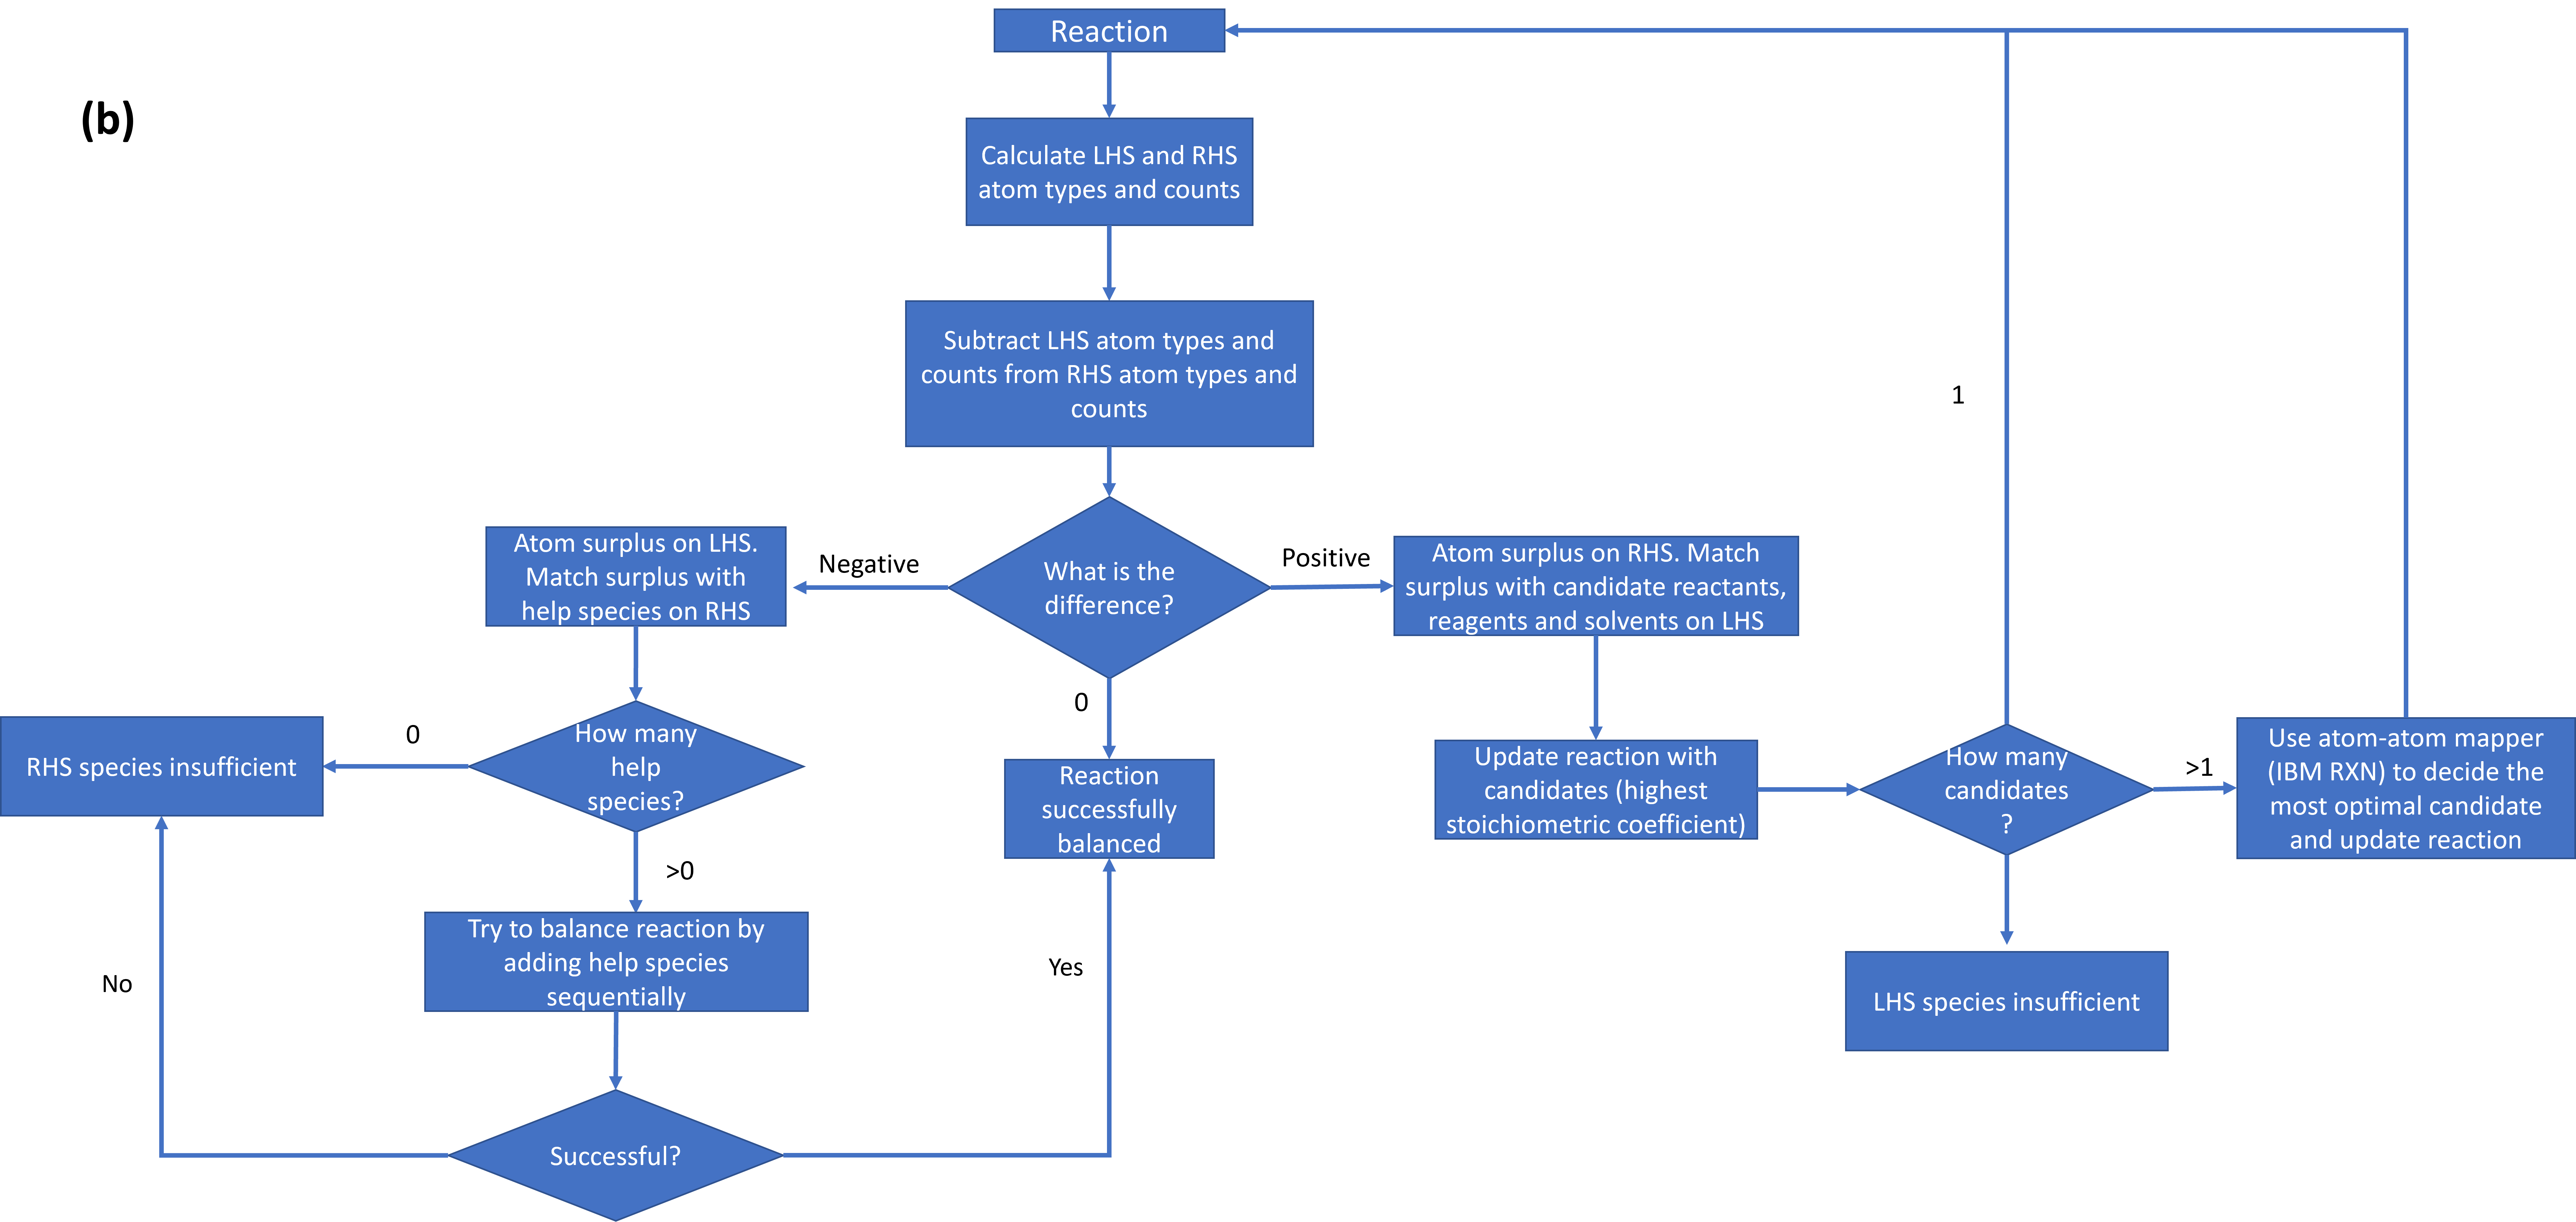

In [15]:
# Reaction source
reactiondir='/home/aa2133/Impurity-Project/Input/Case4.4/DataMining/analoguerxns.pickle'
# Updated reaction source (with reactant, product, reagent, solvent dictionaries)
updatedreactiondir='/home/aa2133/Impurity-Project/Input/Case4.4/DataProcessing/analoguerxns_updated.pickle'
# Substance database source
substancesource=masterdbreadpath+'SubstanceSmiles.pickle'

In [16]:
import pandas as pd

In [18]:
reactions=pd.read_pickle(reactiondir)

In [19]:
updatedreactions=pd.read_pickle(updatedreactiondir)

Taking a small sample (100 reactions currently. Change this number to whatever is desired)

In [20]:
updatedreactionsample=updatedreactions[:100]
updatedreactionsample
updatedreactionsample.dtypes
updatedreactionsample[['Rdata','Pdata','Rgtdata','Solvdata','hc_prod']]

,,Rdata,Pdata,Rgtdata,Solvdata,hc_prod
ReactionID,Instance,,,,,
290521,0,"{1947445: {'atomdict': {'O': 3, 'C': 9, 'H': 1...","{2873491: {'atomdict': {'C': 18, 'O': 3, 'H': ...","{1718733: {'atomdict': {'C': 2, 'O': 1, 'H': 6...",{},"{0: {'atomdict': {'C': 2, 'O': 2, 'H': 4}, 'ch..."
1905467,0,"{1718945: {'atomdict': {'C': 4, 'O': 2, 'H': 1...","{6323604: {'atomdict': {'C': 14, 'O': 3, 'H': ...",{},"{1730763: {'atomdict': {'C': 7, 'H': 16}, 'cha...","{0: {'atomdict': {'C': 2, 'O': 2, 'H': 4}, 'ch..."
8638798,0,"{742035: {'atomdict': {'O': 2, 'C': 2, 'F': 3,...","{8670162: {'atomdict': {'C': 23, 'N': 6, 'O': ...",{},"{1730800: {'atomdict': {'Cl': 2, 'C': 1, 'H': ...","{0: {'atomdict': {'C': 2, 'O': 2, 'H': 4}, 'ch..."
9407668,0,"{5881591: {'atomdict': {'N': 2, 'C': 20, 'S': ...","{9544453: {'atomdict': {'Co': 1, 'C': 80, 'S':...","{3692529: {'atomdict': {'C': 2, 'O': 2, 'Co': ...",{},"{0: {'atomdict': {'C': 2, 'O': 2, 'H': 4}, 'ch..."
23064954,0,"{14270456: {'atomdict': {'C': 32, 'N': 4, 'O':...","{11970034: {'atomdict': {'C': 27, 'N': 4, 'O':...","{742035: {'atomdict': {'O': 2, 'C': 2, 'F': 3,...","{1730800: {'atomdict': {'Cl': 2, 'C': 1, 'H': ...","{0: {'atomdict': {'C': 2, 'O': 2, 'H': 4}, 'ch..."
...,...,...,...,...,...,...
3754768,0,"{5885728: {'atomdict': {'C': 17, 'N': 2, 'O': ...","{5899305: {'atomdict': {'C': 14, 'N': 2, 'O': ...",{},"{3587155: {'atomdict': {'O': 1, 'H': 2}, 'char...","{0: {'atomdict': {'C': 2, 'O': 2, 'H': 4}, 'ch..."
8991996,0,"{108570: {'atomdict': {'O': 1, 'C': 4, 'N': 2,...","{9072348: {'atomdict': {'C': 18, 'N': 7, 'H': ...",{},"{605264: {'atomdict': {'Cl': 2, 'C': 2, 'H': 4...","{0: {'atomdict': {'C': 2, 'O': 2, 'H': 4}, 'ch..."
23662036,0,"{6136720: {'atomdict': {'N': 1, 'C': 7, 'B': 1...","{14488552: {'atomdict': {'N': 1, 'C': 9, 'B': ...",{},"{102391: {'atomdict': {'C': 4, 'O': 1, 'H': 8}...","{0: {'atomdict': {'C': 2, 'O': 2, 'H': 4}, 'ch..."


Passing in a SMILES string

In [17]:
finaldf=masterbalance('O=C(O)CS.Cc1cc(OC(C)c2nnc(N=Cc3ccccc3)s2)ccc1Cl>>Cc1cc(OC(C)c2nnc(N3C(=O)CSC3c3ccccc3)s2)ccc1Cl',ncpus=1)
finaldf

Reaction successfully balanced


Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.
Keyword arguments {'return_special_tokens_masks': True} not recognized.


,,NumRefs,NumSteps,NumStages,rxnsmiles0,balrxnsmiles,msg,LHS,RHS,hcrct,hcprod,LHSdata,RHSdata,mapped_rxn,confidence,msg1
ReactionID,Instance,,,,,,,,,,,,,,,
0,0,1,1,1,O=C(O)CS.Cc1cc(OC(C)c2nnc(N=Cc3ccccc3)s2)ccc1C...,O=C(O)CS.Cc1cc(OC(C)c2nnc(N=Cc3ccccc3)s2)ccc1C...,Balanced with help product(s): H2O,"[0, 1]",[0],[],[1],"{0: {'atomdict': {'O': 2, 'C': 2, 'S': 1, 'H':...","{0: {'atomdict': {'C': 20, 'O': 2, 'N': 3, 'S'...",[C:13](=[O:14])([CH2:15][SH:16])[OH:29].[CH3:1...,0.870231,Valid


Passing in a dataframe, with updated dictionaries for each substance under Rdata (reactants), Rgtdata (reagents), Solvdata (solvents) and Pdata (products).

In [22]:
finaldf=masterbalance(updatedreactionsample,ncpus=1)

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.
Keyword arguments {'return_special_tokens_masks': True} not recognized.


Reaction successfully balanced
Help compounds did not help. Extra reactant atoms


Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.
Keyword arguments {'return_special_tokens_masks': True} not recognized.


Help compounds did not help. Extra reactant atoms
Help compounds did not help. Extra reactant atoms
Reaction successfully balanced
Reaction successfully balanced
Reaction successfully balanced
Reaction is fully balanced
Help compounds did not help. Extra reactant atoms
Reaction successfully balanced
Reaction successfully balanced
Help compounds did not help. Extra reactant atoms
Help compounds did not help. Extra reactant atoms
Help compounds did not help. Extra reactant atoms
Reaction is fully balanced
Reaction is fully balanced
Reaction is fully balanced
Reaction is fully balanced
Help compounds did not help. Extra reactant atoms


Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.
Keyword arguments {'return_special_tokens_masks': True} not recognized.


Help compounds did not help. Extra reactant atoms
Reaction successfully balanced
Reaction successfully balanced
Reaction successfully balanced
Reaction is fully balanced
Help compounds did not help. Extra reactant atoms
Help compounds did not help. Extra reactant atoms
Reaction is fully balanced
Reaction successfully balanced
Reaction successfully balanced
Help compounds did not help. Extra reactant atoms
Help compounds did not help. Extra reactant atoms
Help compounds did not help. Extra reactant atoms
Reaction successfully balanced
Help compounds did not help. Extra reactant atoms
Reaction successfully balanced
Reaction successfully balanced
Help compounds did not help. Extra reactant atoms


Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.
Keyword arguments {'return_special_tokens_masks': True} not recognized.


Help compounds did not help. Extra reactant atoms
Help compounds did not help. Extra reactant atoms
Help compounds did not help. Extra reactant atoms
Reaction successfully balanced
Help compounds did not help. Extra reactant atoms
Help compounds did not help. Extra reactant atoms
Help compounds did not help. Extra reactant atoms
Reaction successfully balanced


Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


Help compounds did not help. Extra reactant atoms


Keyword arguments {'return_special_tokens_masks': True} not recognized.


Reaction is fully balanced
Help compounds did not help. Extra reactant atoms
Reaction successfully balanced
Reaction successfully balanced
Reaction successfully balanced
Reaction successfully balanced
Reaction is fully balanced
Reaction is fully balanced
Reaction is fully balanced
Help compounds did not help. Extra reactant atoms
Reaction successfully balanced
Reaction successfully balanced
Help compounds did not help. Extra reactant atoms
Help compounds did not help. Extra reactant atoms
Reaction is fully balanced
Help compounds did not help. Extra reactant atoms
Help compounds did not help. Extra reactant atoms
Help compounds did not help. Extra reactant atoms
Reaction is fully balanced
Reaction is fully balanced
Reaction is fully balanced
Help compounds did not help. Extra reactant atoms


Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.
Keyword arguments {'return_special_tokens_masks': True} not recognized.


Help compounds did not help. Extra reactant atoms
Help compounds did not help. Extra reactant atoms
Reaction successfully balanced
Help compounds did not help. Extra reactant atoms
Reaction successfully balanced
Reaction is fully balanced
Help compounds did not help. Extra reactant atoms
Help compounds did not help. Extra reactant atoms
Reaction successfully balanced
Reaction successfully balanced


Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.
Keyword arguments {'return_special_tokens_masks': True} not recognized.


Reaction successfully balanced
Reaction is fully balanced


Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.
Keyword arguments {'return_special_tokens_masks': True} not recognized.
Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.
Keyword arguments {'return_special_tokens_masks': True} not recognized.
Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.
Keyword arguments {'return_special_tokens_masks': True} not recognized.
Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.
Keyword arguments {'return_special_tokens_masks': True} not recognized.
Sett

Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.
Keyword arguments {'return_special_tokens_masks': True} not recognized.
Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.
Keyword arguments {'return_special_tokens_masks': True} not recognized.
Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.
Keyword arguments {'return_special_tokens_masks': True} not recognized.
Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.
Keyword arguments {'return_special_tokens_masks': True} not recognized.
Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Sett

Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.
Keyword arguments {'return_special_tokens_masks': True} not recognized.
Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.
Keyword arguments {'return_special_tokens_masks': True} not recognized.
Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.
Keyword arguments {'return_special_tokens_masks': True} not recognized.
Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.
Keyword arguments {'return_special_tokens_masks': True} not recognized.
Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Sett

To speed up the workflow, specify ncpus > 1 so Ray and Modin can be used to parallelize operations across cores

In [257]:
finaldf=masterbalance(updatedreactionsample,ncpus=16)

2022-06-16 01:36:09,540	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265
2022-06-16 01:36:19,555	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265
2022-06-16 01:36:29,498	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


In [25]:
finaldf
numbalanced=len(finaldf.loc[finaldf.msg.str.contains('balanced',case=False,na=False)])
print(str(numbalanced)+' reactions were balanced')

,,NumRefs,NumSteps,NumStages,rxnsmiles0,balrxnsmiles,msg,LHS,RHS,hcrct,hcprod,LHSdata,RHSdata,mapped_rxn,confidence,msg1
ReactionID,Instance,,,,,,,,,,,,,,,
290521,0,1,1,1,O=C(O)CCc1cccc(O)c1>>CCOC(=O)CCc1cccc(OCc2cccc...,O=C(O)CCc1cccc(O)c1.O=C(O)CCc1cccc(O)c1.O=C(O)...,Balanced with help product(s): O2,"[1947445, 1947445, 1947445, 1947445]","[2873491, 2873491]",[],[3],"{1947445: {'atomdict': {'O': 3, 'C': 9, 'H': 1...","{2873491: {'atomdict': {'C': 18, 'O': 3, 'H': ...",[CH2:14]([c:15]1[cH:16][cH:17][cH:18][c:19]([O...,0.003289,Valid
1905467,0,1,1,1,CC(O)CCO.CCCCCCCCCC(=O)O>>CCCCCCCCCC(=O)OCCC(C...,CCCCCCCCCC(=O)O.CCCCCCCCCC(=O)O.CC(O)CCO.CC(O)...,"Mapper used, RHS species insufficient with spe...","[1754556, 1754556, 1718945, 1718945]","[6323604, 6323607]",[],[],"{1754556: {'atomdict': {'C': 10, 'O': 2, 'H': ...","{6323604: {'atomdict': {'C': 14, 'O': 3, 'H': ...",O[C:10]([CH2:9][CH2:8][CH2:7][CH2:6][CH2:5][CH...,0.189347,Valid
8638798,0,1,1,1,O=C(O)C(F)(F)F.C[C@H](NC(=O)CNC(=NC(=O)OC(C)(C...,O=C(O)C(F)(F)F.C[C@H](NC(=O)CNC(=NC(=O)OC(C)(C...,RHS species insufficient,"[742035, 8667639]",[8670162],[],[],"{8667639: {'atomdict': {'C': 31, 'N': 6, 'O': ...","{8670162: {'atomdict': {'C': 23, 'N': 6, 'O': ...",CC(C)(C)OC(=O)[N:9]=[C:8]([NH:7][CH2:6][C:4]([...,0.158664,Mixture detected for RHS species: 8670162
9407668,0,1,1,1,N#Cc1cc(Sc2ccccc2)c(Sc2ccccc2)cc1C#N>>[Co+2].c...,N#Cc1cc(Sc2ccccc2)c(Sc2ccccc2)cc1C#N.N#Cc1cc(S...,"Mapper used, Mixture detected for LHS species:...","[5881591, 5881591, 5881591, 5881591, 3692529]",[9544453],[],[],"{5881591: {'atomdict': {'N': 2, 'C': 20, 'S': ...","{9544453: {'atomdict': {'Co': 1, 'C': 80, 'S':...",CC(=O)[O-].[C:28](#[N:29])[c:75]1[c:56]([C:30]...,0.001764,"Mixture detected for LHS species: 3692529, Mix..."
23064954,0,1,1,1,CC1CC1CNc1cc(C(=O)N[C@@H](Cc2ccccc2)C(=O)CN(C(...,CC1CC1CNc1cc(C(=O)N[C@@H](Cc2ccccc2)C(=O)CN(C(...,RHS species insufficient,[14270456],[11970034],[],[],"{14270456: {'atomdict': {'C': 32, 'N': 4, 'O':...","{11970034: {'atomdict': {'C': 27, 'N': 4, 'O':...",CC(C)(C)OC(=O)[N:24]([CH2:23][C:21]([C@@H:13](...,0.560173,Valid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3754768,0,1,1,1,C[C@@H](NC(=O)OC(C)(C)C)C(=O)N[C@@H](Cc1ccc(Br...,C[C@@H](NC(=O)OC(C)(C)C)C(=O)N[C@@H](Cc1ccc(Br...,RHS species insufficient,"[5885728, 742035]",[5899305],[],[],"{5885728: {'atomdict': {'C': 17, 'N': 2, 'O': ...","{5899305: {'atomdict': {'C': 14, 'N': 2, 'O': ...",CC(C)(C)OC(=O)[NH:3][C@H:2]([CH3:1])[C:4](=[O:...,0.314384,Mixture detected for RHS species: 5899305
8991996,0,1,1,1,OCn1cccn1.Cc1cc(C)n(CCNCCn2nc(C)cc2C)n1>>Cc1cc...,OCn1cccn1.Cc1cc(C)n(CCNCCn2nc(C)cc2C)n1>>Cc1cc...,Balanced with help product(s): H2O,"[108570, 6148999]",[9072348],[],[1],"{108570: {'atomdict': {'O': 1, 'C': 4, 'N': 2,...","{9072348: {'atomdict': {'C': 18, 'N': 7, 'H': ...",[CH2:19]([n:20]1[cH:21][cH:22][cH:23][n:24]1)[...,0.94626,Valid
23662036,0,2,1,1,N#Cc1cccc(B(O)O)c1.OCCO>>N#Cc1cccc(B(O)OCCO)c1,N#Cc1cccc(B(O)O)c1.OCCO>>N#Cc1cccc(B(O)OCCO)c1.O,Balanced with help product(s): H2O,"[6136720, 505945]",[14488552],[],[1],"{505945: {'atomdict': {'O': 2, 'C': 2, 'H': 6}...","{14488552: {'atomdict': {'N': 1, 'C': 9, 'B': ...",[CH2:11]([CH2:12][OH:13])[OH:15].[N:1]#[C:2][c...,0.641525,Valid


44 reactions were balanced


Visualising reactions can be done as shown below (visoutput shows per row, visoutput2 allows the user to specify a Reaction ID and instance). Any errors or comments are also shown

In [26]:
visoutput(finaldf)
visoutput2(finaldf)

IntSlider(value=0, description='Row Number', max=99)

Output()

IntSlider(value=290521, description='Reaxys ID', max=47336157, min=290521)

IntSlider(value=0, description='Instance', max=0)

Output()